# Draw skeleton for the Keraal Dataset

This python notebook is used to visualise the skeleton data from the Keraal Dataset. More information on this dataset can be read in http://nguyensmai.free.fr/KeraalDataset.html.

More information about this code and how to use it can be read in https://github.com/nguyensmai/KeraalDataset.

If you find this code useful, please consider citing :

```
@article{Blanchard2022BRI,
	author = {Agathe Blanchard and Sao Mai Nguyen and Maxime Devanne and Mathieu Simonnet and Myriam Le Goff-Pronost and Olivier Remy-Neris},
	journal = {BioMed Research International},
	month = {mar},
	pages = {1--10},
	title = {Technical Feasibility of Supervision of Stretching Exercises by a Humanoid Robot Coach for Chronic Low Back Pain: The R-COOL Randomized Trial},
	volume = {2022},
	year = 2022}
```


## Download and load external files

Please download first the lib folder and the data folder from https://github.com/nguyensmai/KeraalDataset or from http://nguyensmai.free.fr/KeraalDataset.html

Put these in your current folder.
If you use this in google colab, upload them in your Drive and mount your drive with the following code

In [1]:
#skip this if you don't need to mount your google drive to your google colab
from google.colab import drive
from google.colab import output
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [2]:
#skip this if you don't need to mount your google drive to your google colab
colab_path = "/content/gdrive/My Drive/Colab Notebooks/"

# Repository compile
%cd $colab_path

/content/gdrive/My Drive/Colab Notebooks


##Python libraries

Install libraries

In [2]:
!pip3 install numpngw imutils

  Preparing metadata (setup.py) ... done
  Created wheel for imutils: filename=imutils-0.5.4-py3-none-any.whl size=25836 sha256=7a9d07eb312c3a4d92faac2fe36ba47238e482f271a28922bfeeb1621564dff7
  Stored in directory: /Users/mai/Library/Caches/pip/wheels/59/1b/52/0dea905f8278d5514dc4d0be5e251967f8681670cadd3dca89
Successfully built imutils


Load libraries

In [3]:
import cv2
import json
import numpy as np
import imutils
import sys
import time
import json
import matplotlib
import matplotlib.pyplot as plt
import math
from lib.utils.common_draw_skeletons import *

## Initalization and utilitary functions

Initalization of variables

In [19]:
#initialize jobs
mvt = "cacheTete"
# mvt = "etirementLateraux"
# mvt = "rotationTronc"

path_openpose='dataSampleKeraal/G3-OP-CTK-P1T1-Unknown-C-0.json'
path_alphapose='dataSampleKeraal/G3-AP-CTK-P1T1-Unknown-C-0.json'
path_blazepose='dataSampleKeraal/G3-BP-CTK-P1T1-Unknown-C-0.json'
path_kinect='dataSampleKeraal/G3-Kinect-CTK-P1T1-Unknown-C-0.txt'
path_vicon='dataSampleKeraal/G3-Vicon-CTK-P1T1-Unknown-C-0.txt'



height=300
width=500
size=(width,height)


Functions to read the data files

In [27]:
#read Json openpose file
def read_json_openpose(path, Body_parts_strToNum):
    with open(path,'r') as f:
        data=f.read()
    
        for i in Body_parts_strToNum:
            data=data.replace(i,str(Body_parts_strToNum[i]))
        json_object=json.loads(data)
    f.close()
    return json_object

#read Json alphapose file
def read_json_alphapose(path):
    with open(path,'r') as f:
        data=f.read()
        json_object=json.loads(data)
        #print(json_object["positions"].keys()) #the frame numbers
        #for key in json_object["positions"].keys(): #printing  the joint positions for each frame
        #    print("key ", key," ", json_object["positions"][key])
    f.close()
    return json_object

#read Kinect txt file and map it to the correct json format
def read_txt_kinect(path):
    with open(path_kinect,'r') as f:
        data = f.read().splitlines()
    f.close()

    tab = {}
    tab1 = {}
    tab1['positions'] = tab

    line = 0
    for i in data:
        line = line+1
        tab[str(float(line))] = {}
        for n in range(25):
            first = i.split(' ')[7*n:7*(n+1)]
            tab[str(float(line))][str(n)] = [first[0], first[1]]
    return tab1

#read Vicon txt file and map it to the correct json format
def read_txt_vicon(path):
    tab= {}
    tab1= {}
    tab1['positions'] = tab
    data_filtred=[]
    
    #read file
    with open(path_vicon,'r') as w:
        data = w.read().splitlines()
    w.close()
    for j in range(0,len(data)):
        if j%2 == 0:
            data_filtred.append(data[j])
#     print(len(data_filtred))
    data = data_filtred
    

#     print('start vicon')
    line=0
    for i in data:
        line=line+1
        tab[str(float(line))]={}
        for n in range(17):
            first=i.split(' ')[7*n:7*(n+1)]
            tab[str(float(line))][str(n)] = [first[0],first[1],first[2],first[3],first[4],first[5],first[6]]
    return tab1



Angles conversion

In [6]:
def euler_from_quaternion(x, y, z, w):
        """
        Convert a quaternion into euler angles (roll, pitch, yaw)
        roll is rotation around x in radians (counterclockwise)
        pitch is rotation around y in radians (counterclockwise)
        yaw is rotation around z in radians (counterclockwise)
        """
        t0 = +2.0 * (w * x + y * z)
        t1 = +1.0 - 2.0 * (x * x + y * y)
        roll_x = math.atan2(t0, t1)
     
        t2 = +2.0 * (w * y - z * x)
        t2 = +1.0 if t2 > +1.0 else t2
        t2 = -1.0 if t2 < -1.0 else t2
        pitch_y = math.asin(t2)
     
        t3 = +2.0 * (w * z + x * y)
        t4 = +1.0 - 2.0 * (y * y + z * z)
        yaw_z = math.atan2(t3, t4)
     
        return [roll_x,pitch_y,yaw_z]

## Functions to draw skeletons

In [75]:
#cocopairs for openpose	
CocoPairs = [
             (1, 2), (1, 5), (2, 3), (3, 4), (5, 6), (6, 7), (1, 8),
             (8, 9), (9, 10), (1, 11),(11, 12), (12, 13), (1, 0), 
             (0, 14), (14, 16), (0, 15), (15, 17), (2, 16), (5, 17)]   
CocoPairsRender = CocoPairs[:-2]
    
#Draw human skeleton function for openpose 
def draw_humans(npimg, humans, CocoColors_parts, CocoColors_pairs):

    
    image_h, image_w = npimg.shape[:2]
#     print(image_h, image_w)
    
    centers = {}
    human_keys=list(map(int, humans.keys()))
        
    # draw point
    for i in range(CocoPart.Background.value):#for each keypoint
            if i not in human_keys:
                continue
            
            body_part = humans[str(i)]
            center = (int(body_part[0] * image_w)-80, int(body_part[1] * image_h + 0.5))
            centers[i] = center
            if(i==1):
                cv2.circle(npimg, center, 9, CocoColors_parts[i], thickness=2, lineType=8, shift=0)
            else:
                cv2.circle(npimg, center, 3, CocoColors_parts[i], thickness=2, lineType=8, shift=0)

    # draw line
    for pair_order, pair in enumerate(CocoPairsRender):
#             print(pair_order, pair[1])
            
            if pair[0] not in human_keys or pair[1] not in human_keys:
                continue
#             print(pair, centers[pair[0]], centers[pair[1]], CocoColors_pairs[pair])
            cv2.line(npimg, centers[pair[0]], centers[pair[1]], CocoColors_pairs[pair], 2)

    return npimg

In [37]:
def convertir_blazepose_en_openpose(bla_temp, dic):
    sklt_bla = list(bla_temp.keys())
#     deep_ref = (bla_temp[sklt_bla[11]][2]+bla_temp[sklt_bla[12]][2])/2
    blaztoOpen = {}
    blaztoOpen[str(dic["Nose"])] = np.array(bla_temp[sklt_bla[0]])
    blaztoOpen[str(dic["Neck"])] = np.array([(bla_temp[sklt_bla[11]][0]+bla_temp[sklt_bla[12]][0])/2,
                                        (bla_temp[sklt_bla[11]][1]+bla_temp[sklt_bla[12]][1])/2,
                                        (bla_temp[sklt_bla[11]][2]+bla_temp[sklt_bla[12]][2])/2])
    ## Right arm
    blaztoOpen[str(dic["rShoulder"])] = np.array(bla_temp[sklt_bla[12]])
    blaztoOpen[str(dic["rElbow"])] = np.array(bla_temp[sklt_bla[14]])
    blaztoOpen[str(dic["rWrist"])] = np.array(bla_temp[sklt_bla[16]])
    ## Left arm
    blaztoOpen[str(dic["lShoulder"])] = np.array(bla_temp[sklt_bla[11]])
    blaztoOpen[str(dic["lElbow"])] = np.array(bla_temp[sklt_bla[13]])
    blaztoOpen[str(dic["lWrist"])] = np.array(bla_temp[sklt_bla[15]])
    ## Right leg
    blaztoOpen[str(dic["rHip"])] = np.array(bla_temp[sklt_bla[24]])
    blaztoOpen[str(dic["rKnee"])] = np.array(bla_temp[sklt_bla[26]])
    blaztoOpen[str(dic["rAnkle"])] = np.array(bla_temp[sklt_bla[28]])
    ## Left leg
    blaztoOpen[str(dic["lHip"])] = np.array(bla_temp[sklt_bla[23]])
    blaztoOpen[str(dic["lKnee"])] = np.array(bla_temp[sklt_bla[25]])
    blaztoOpen[str(dic["lAnkle"])] = np.array(bla_temp[sklt_bla[27]])

    return blaztoOpen  

In [38]:
# Draw human skeleton function for Kinect
Body_parts_kinect={0: 'SpineBase' ,1: 'SpineMid',2: 'Neck',3: 'Head',
                       4: 'ShoulderLeft',5: 'ElbowLeft',6: 'WristLeft',7: 'HandLeft',
                       8: 'ShoulderRight',9: 'ElbowRight',10: 'WristRight',
                       11: 'HandRight',12: 'HipLeft',13: 'KneeLeft',14: 'AnkleLeft',
                       15: 'FootLeft',16: 'HipRight',17: 'KneeRight',18: 'AnkleRight',
                       19: 'FootRight',20: 'SpineShoulder',21: 'HandTipLeft',
                       22: 'ThumbLeft',23: 'HandTipRight',24: 'ThumbRight'}
    
# Defining the skeletons pairs
CocoPairsRender_kn = [(0,1),(1,2),(2,3), (2,4),(4,5),(5,6),(6,7),
                    (2,8),(8,9),(9,10),(10,11),(0,12),(12,13),(13,14),
                    (14,15),(0,16),(16,17),(17,18),(18,19)]

def draw_humans_kinect(npimg, humans):

    image_h, image_w = npimg.shape[:2]
#     print(image_h, image_w)
    
    centers = {}
    human_keys=list(map(int, humans.keys()))
#     print(human_keys)
   
    # draw point
    for i in range(len(CocoColors_parts_kn)-1):
            if i not in human_keys:
#                 print (i)
                continue
            
            body_part = sklt[str(i)]
            center = (image_w-int((float(body_part[0]) * image_w + 200)/3.5+100), int((float(body_part[1]) * image_h + 200)/3.5+100))
            centers[i] = center
#             print(center)
            
            cv2.circle(npimg, center, 3, CocoColors_parts_kn[i], thickness=2, lineType=8, shift=0)
            
        # draw line
    
#     print(enumerate(CocoPairsRender_kn))
    for pair_order, pair in enumerate(CocoPairsRender_kn):
#             print(pair_order, pair[1])
#             print(pair)
            
            if pair[0] not in human_keys or pair[1] not in human_keys:
                continue
#             print(centers[pair[0]], centers[pair[1]], CocoColors_pairs_kn[pair])
            cv2.line(npimg, centers[pair[0]], centers[pair[1]], CocoColors_pairs_kn[pair], 2)

    return npimg


In [39]:
#Draw human skeleton function for Vicon 

#    CocoPairs_vc=[(8,7),(7,2),(8,1),(2,0),(3,1),(0,9),(3,10),
#                  (14,4),(4,13),(13,5),(13,6),(5,15),(6,16),(11,15),(12,16)]
CocoPairs_vc=[(8,7),(7,2),(8,3),(0,2),(1,3),(0,9),(1,10),
              (14,4),(4,13),(13,5),(13,6),(5,15),(6,16),(11,15),(12,16)]

def draw_vicon_3d(i, image_w, image_h):
    fig = plt.figure()
    #ax = fig.add_subplot(projection='3d')
    ax = plt.axes(projection='3d')
    X=[]
    Y=[]
    Z=[]
    for j in range(0,len(openpose_coord_vc['positions'][str(float(i))])):
        #print(str(i))
                pos_head=openpose_coord_vc['positions'][str(float(i))][str(0)]
                param_x=0.5*image_w-float(pos_head[0])
                param_y=0.5*image_h-float(pos_head[1])
                md_pt=openpose_coord_vc['positions'][str(float(i))][str(j)]
                #X.append(float(md_pt[0])*image_w/600-param_x)
                #Y.append(float(md_pt[1])*image_h/600-param_y)
                X.append(float(md_pt[0])*image_w/600)
                Y.append(image_h - float(md_pt[1])*image_h/600-500)
                Z.append(float(md_pt[2])/600)

    res=euler_from_quaternion(float(md_pt[3]),float(md_pt[4]),float(md_pt[5]),float(md_pt[6]))
    ax.scatter3D(X, Y, Z, color=(0,1,0) ,s=53 ,marker='o')
    ax.set_facecolor('xkcd:black')
    ax.set_ylim3d(-400,400)
    #ax.set_xlim3d(30,400)
    ax.set_xlim3d(-200,800)
    
    #ax.set_zlim3d(-40,40)
    for pair in CocoPairs_vc:
        X_pair=[X[pair[0]],X[pair[1]]]
        Y_pair=[Y[pair[0]],Y[pair[1]]]
        Z_pair=[Z[pair[0]],Z[pair[1]]]
        ax.plot(X_pair,Y_pair,Z_pair,color='green',linewidth=5)	
    ax.view_init(res[1], res[0])
    plt.grid(b=None)
    plt.axis('off')
    plt.subplots_adjust(bottom=0.01)
    fig.canvas.draw()
    img = np.fromstring(fig.canvas.tostring_rgb(), dtype=np.uint8,sep='')
    img  = img.reshape(fig.canvas.get_width_height()[::-1] + (3,))
    img = cv2.cvtColor(img,cv2.COLOR_RGB2BGR)
    img[np.where((img==[255,255,255]).all(axis=2))] = [0,0,0]
    return img

In [46]:
ap_body_parts = ['nose', 'l_eye', 'r_eye', 'l_ear', 'r_ear', 'l_shoulder',
        'r_shoulder', 'l_elbow', 'r_elbow', 'l_wrist', 'r_wrist',
        'l_hip', 'r_hip', 'l_knee', 'r_knee', 'l_ankle', 'r_ankle']
def convertir_alphapose_en_openpose(bla_temp, dic):
    sklt_bla = list(bla_temp.keys())
#     deep_ref = (bla_temp[sklt_bla[11]][2]+bla_temp[sklt_bla[12]][2])/2
    alphtoOpen = {}
    alphtoOpen[str(dic["Nose"])] = np.array(bla_temp[sklt_bla[0]])
    alphtoOpen[str(dic["Neck"])] = np.array([(bla_temp[sklt_bla[5]][0]+bla_temp[sklt_bla[6]][0])/2,
                                        (bla_temp[sklt_bla[5]][1]+bla_temp[sklt_bla[6]][1])/2
                                        ])
    ## Right arm
    alphtoOpen[str(dic["rShoulder"])] = np.array(bla_temp[sklt_bla[6]])
    alphtoOpen[str(dic["rElbow"])] = np.array(bla_temp[sklt_bla[8]])
    alphtoOpen[str(dic["rWrist"])] = np.array(bla_temp[sklt_bla[10]])
    ## Left arm
    alphtoOpen[str(dic["lShoulder"])] = np.array(bla_temp[sklt_bla[5]])
    alphtoOpen[str(dic["lElbow"])] = np.array(bla_temp[sklt_bla[7]])
    alphtoOpen[str(dic["lWrist"])] = np.array(bla_temp[sklt_bla[9]])
    ## Right leg
    alphtoOpen[str(dic["rHip"])] = np.array(bla_temp[sklt_bla[12]])
    alphtoOpen[str(dic["rKnee"])] = np.array(bla_temp[sklt_bla[14]])
    alphtoOpen[str(dic["rAnkle"])] = np.array(bla_temp[sklt_bla[16]])
    ## Left leg
    alphtoOpen[str(dic["lHip"])] = np.array(bla_temp[sklt_bla[11]])
    alphtoOpen[str(dic["lKnee"])] = np.array(bla_temp[sklt_bla[13]])
    alphtoOpen[str(dic["lAnkle"])] = np.array(bla_temp[sklt_bla[15]])
    #Eyes rEye':14, 'lEye':15
    alphtoOpen[str(dic["rEye"])] = np.array(bla_temp[sklt_bla[2]])
    alphtoOpen[str(dic["lEye"])] = np.array(bla_temp[sklt_bla[1]])
    return alphtoOpen 

In [47]:
# Body_parts_0={0:'Nose',1:'Neck',2:'rShoulder',3:'rElbow',4:'rWrist',5:'lShoulder',6:'lElbow',7:'lWrist',8:'rHip',9:'rKnee',10:'rAnkle',11:'lHip',12:'lKnee',13:'lAnkle',14:'rEye', 15:'lEye',16:'rEar', 17:'lEar'}
Body_parts_strToNum={'Nose':0 ,'Neck':1 ,'rShoulder':2, 'rElbow':3, 'rWrist':4, 'lShoulder':5,'lElbow':6,'lWrist':7,'rHip':8,'rKnee':9,'rAnkle':10,'lHip':11,'lKnee':12,'lAnkle':13,'rEye':14, 'lEye':15,'rEar':16, 'lEar':17  }

########################Prepare Skeletons data#################################

openpose_coord = read_json_openpose(path_openpose, Body_parts_strToNum)
print(len(openpose_coord["positions"].keys()))

openpose_coord_ap = read_json_alphapose(path_alphapose)
print(len(openpose_coord_ap["positions"].keys()))

openpose_coord_kn = read_txt_kinect(path_kinect)
print(len(openpose_coord_kn["positions"].keys()))

openpose_coord_vc = read_txt_vicon(path_vicon)
print(len(openpose_coord_vc["positions"].keys()))

#read blazepose data
with open(path_blazepose,"rb") as f:
    blaze_coord = json.loads(f.read())
f.close()
print(len(blaze_coord["positions"].keys()))

197
195
197
195
196


/var/folders/xc/7sp6q8653dq_2ykd9dtc83qh0000gn/T/ipykernel_32742/1001999185.py:41: MatplotlibDeprecationWarning: The 'b' parameter of grid() has been renamed 'visible' since Matplotlib 3.5; support for the old name will be dropped two minor releases later.
  plt.grid(b=None)
/var/folders/xc/7sp6q8653dq_2ykd9dtc83qh0000gn/T/ipykernel_32742/1001999185.py:45: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  img = np.fromstring(fig.canvas.tostring_rgb(), dtype=np.uint8,sep='')
/var/folders/xc/7sp6q8653dq_2ykd9dtc83qh0000gn/T/ipykernel_32742/1001999185.py:9: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = plt.figure()


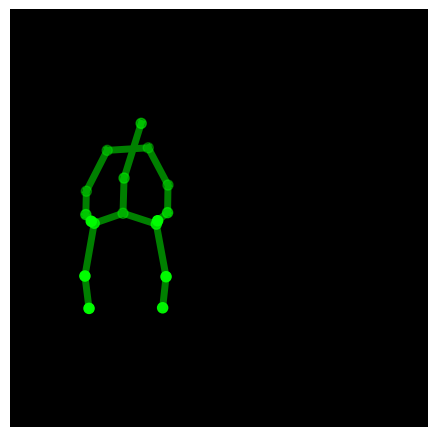

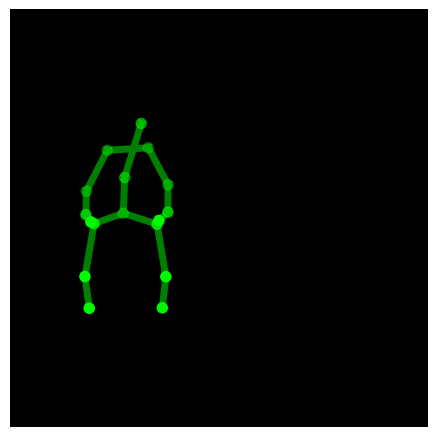

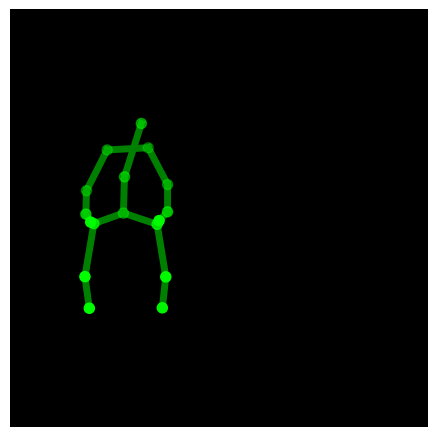

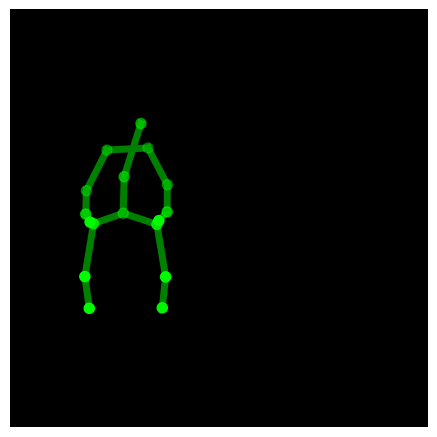

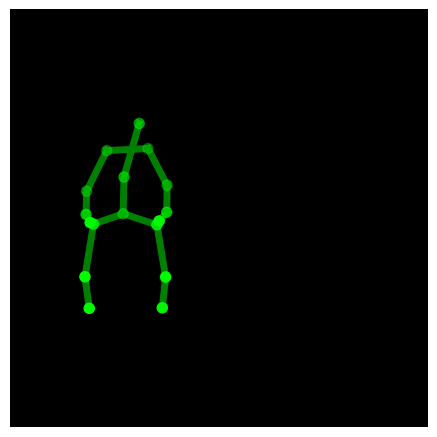

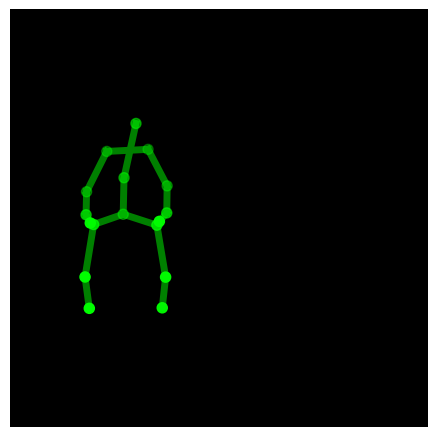

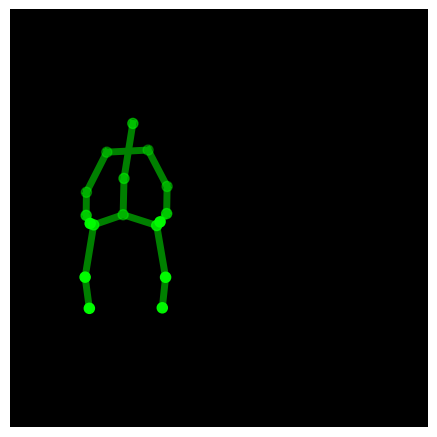

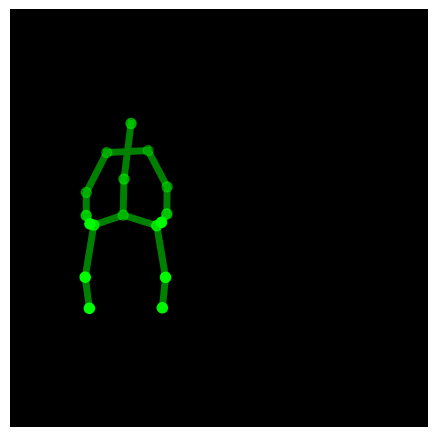

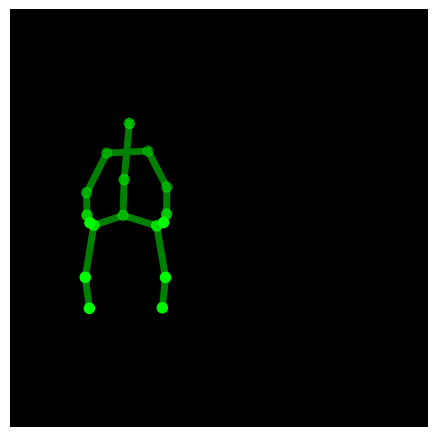

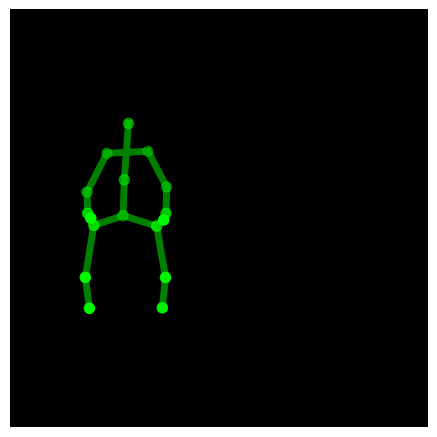

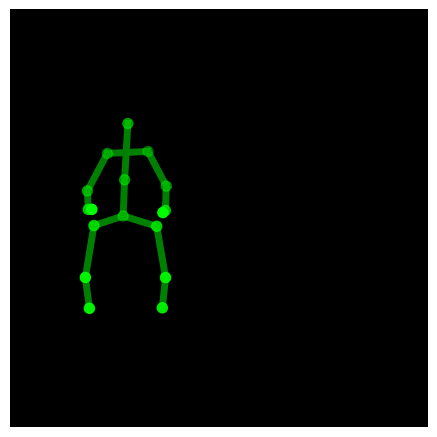

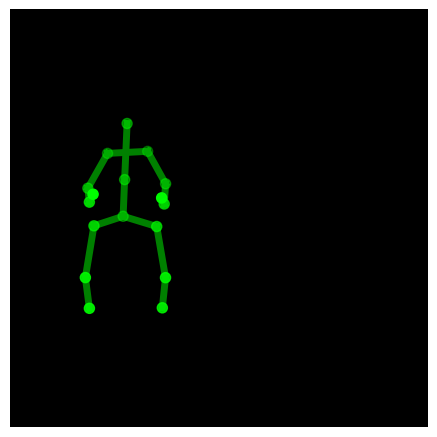

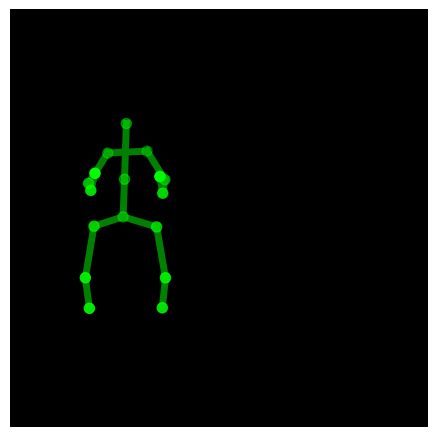

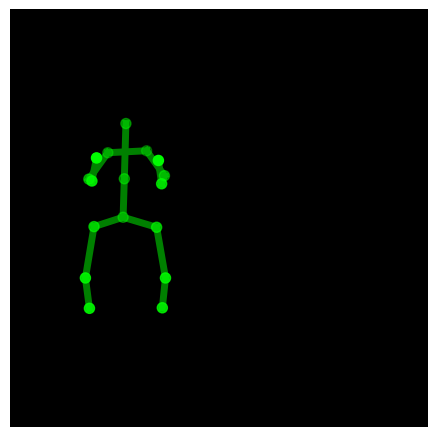

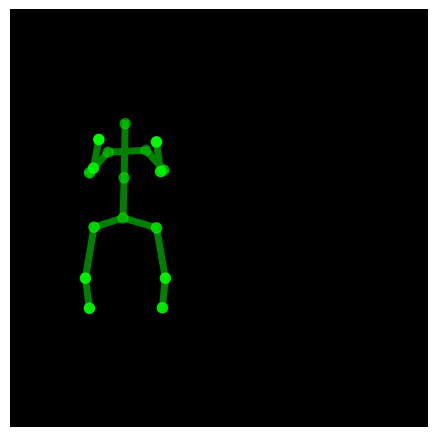

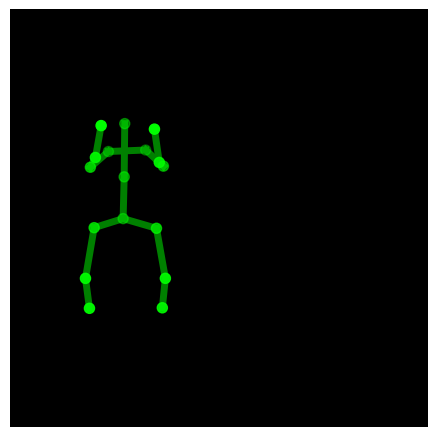

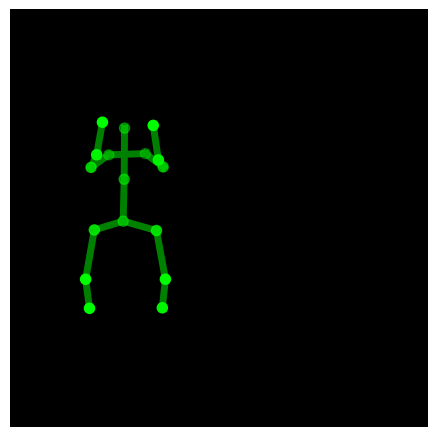

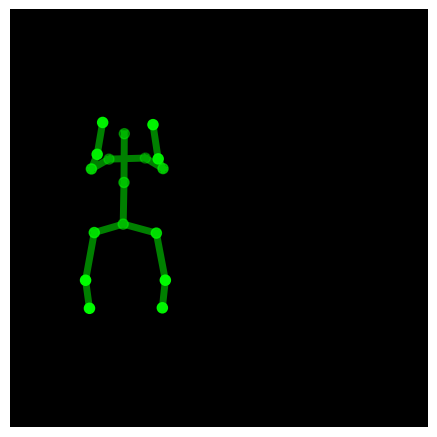

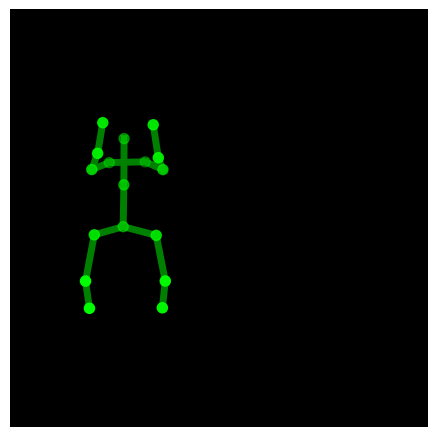

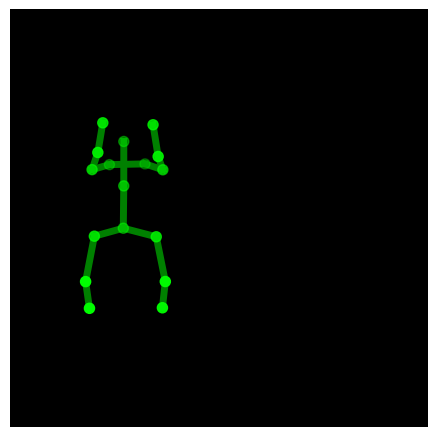

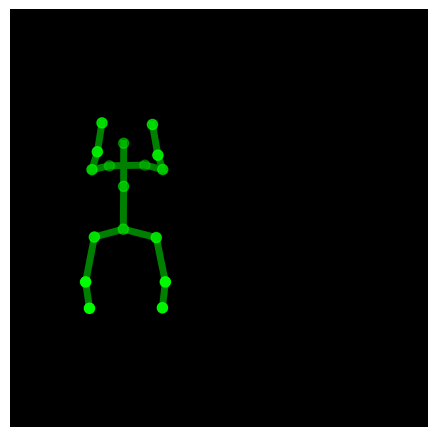

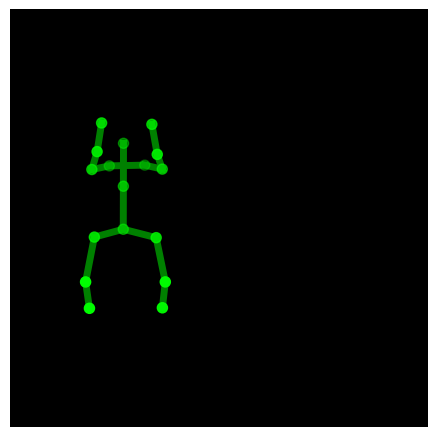

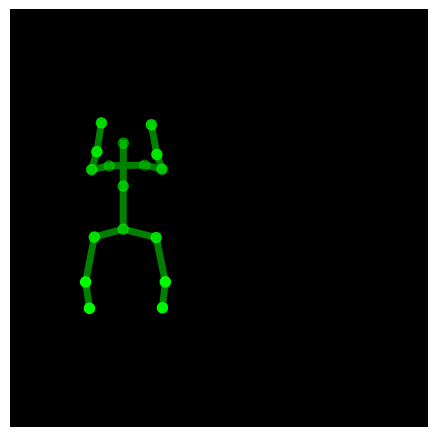

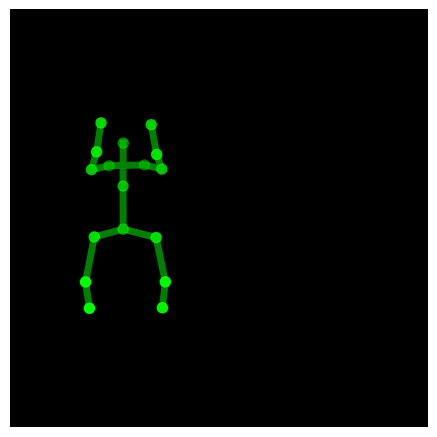

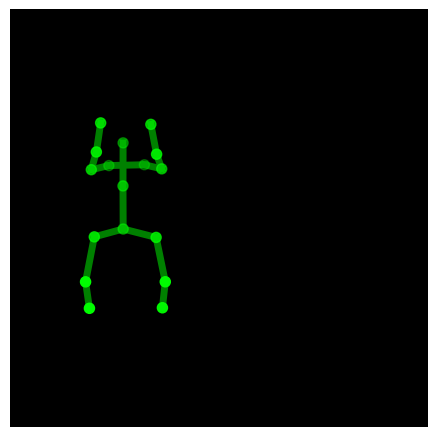

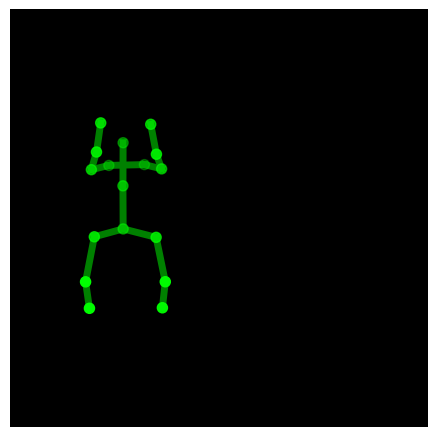

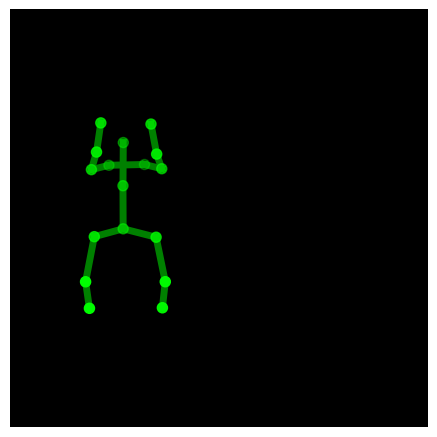

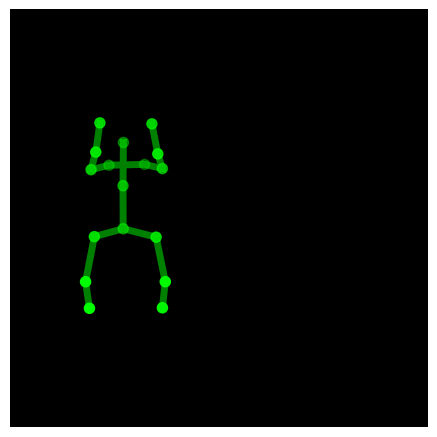

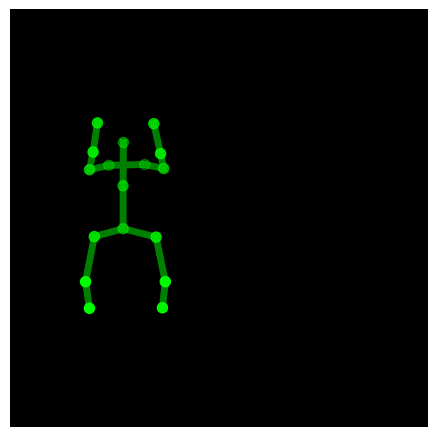

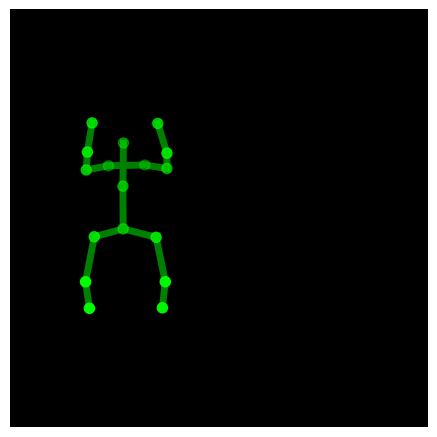

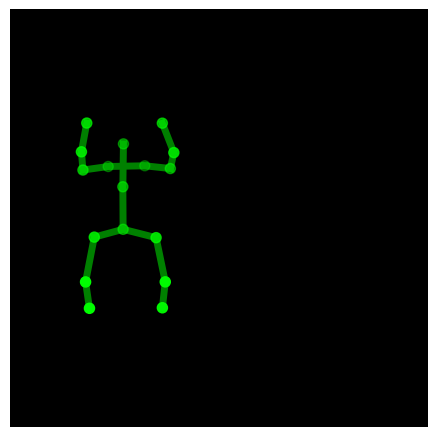

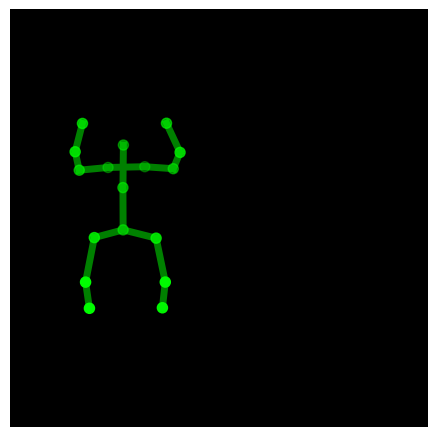

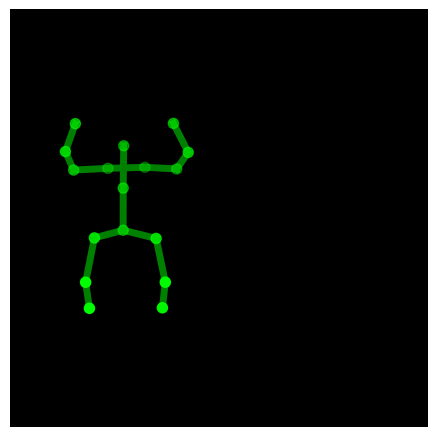

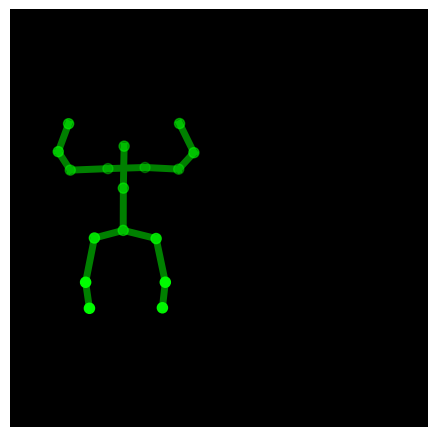

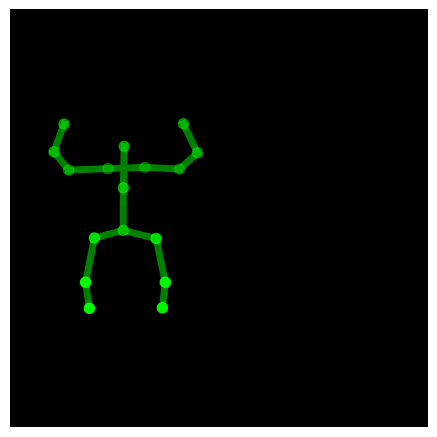

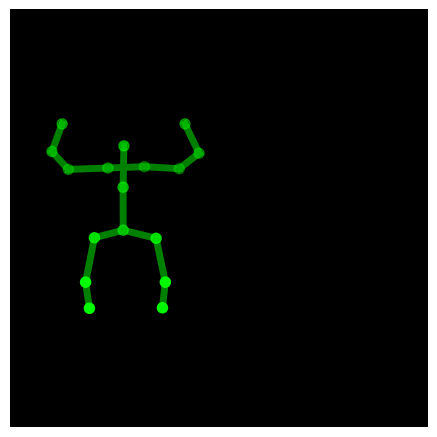

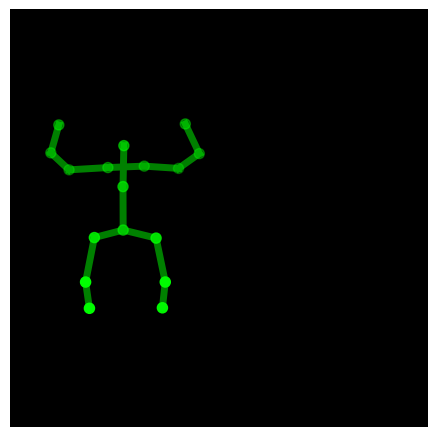

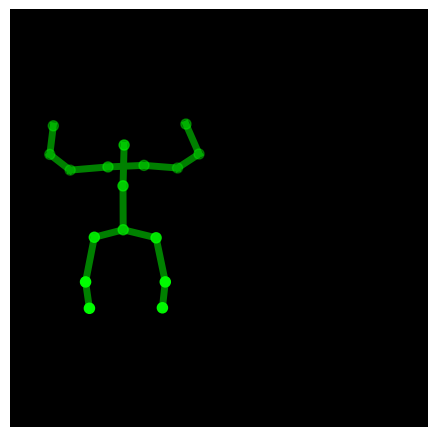

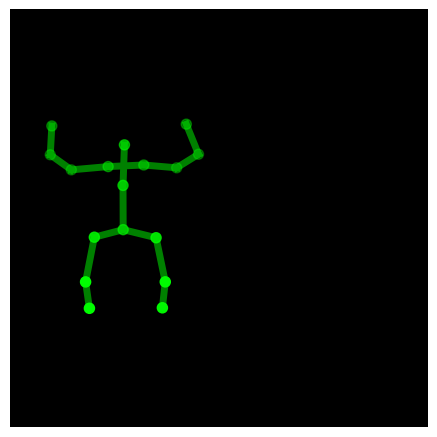

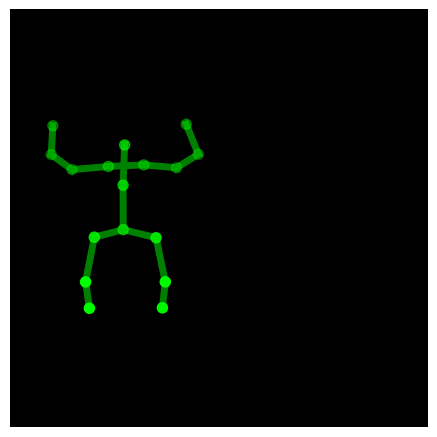

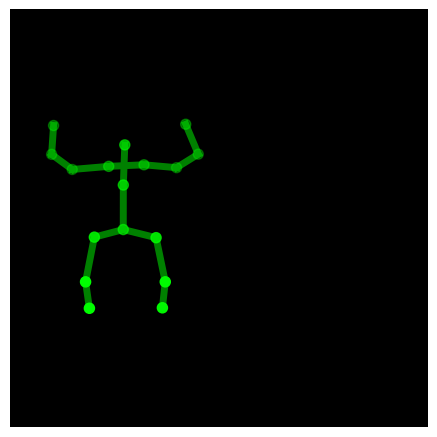

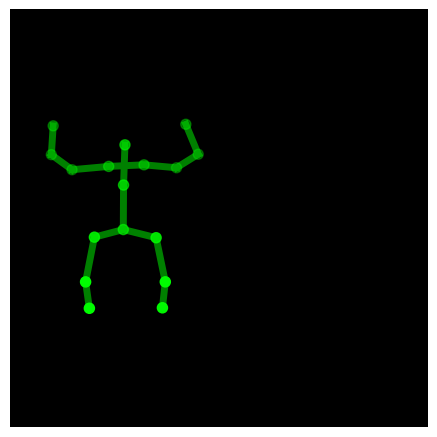

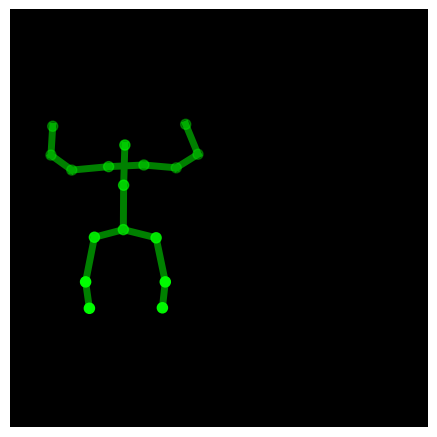

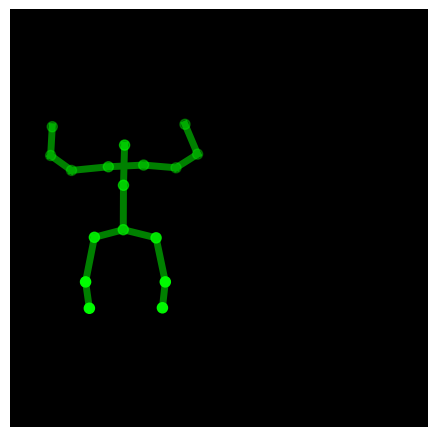

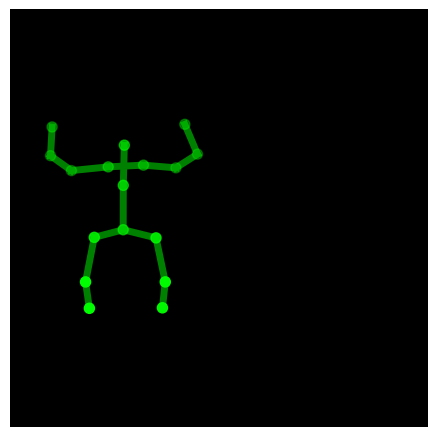

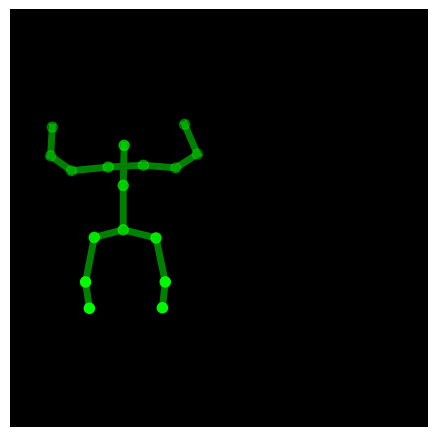

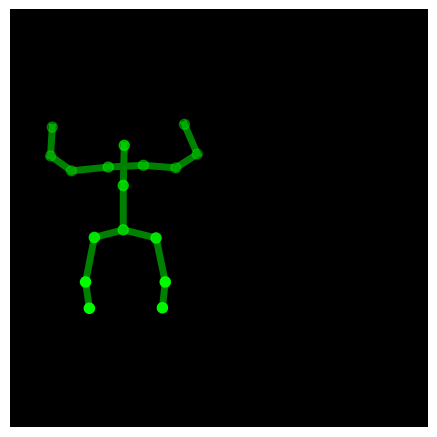

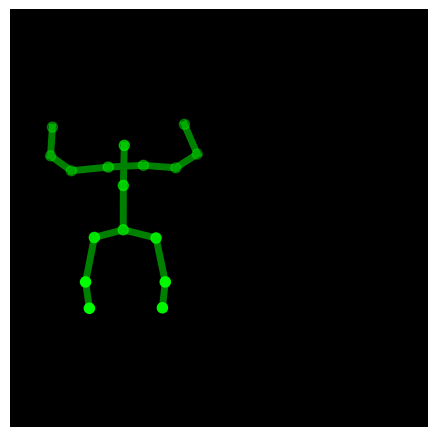

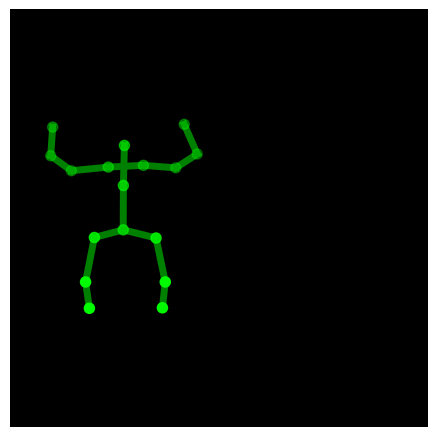

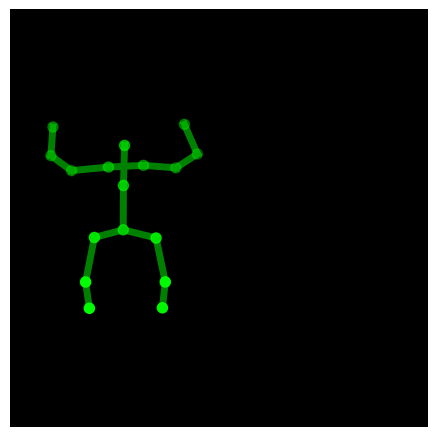

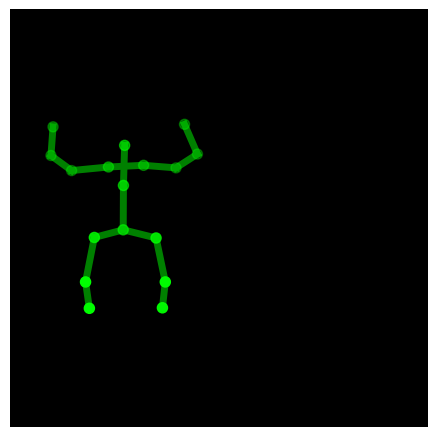

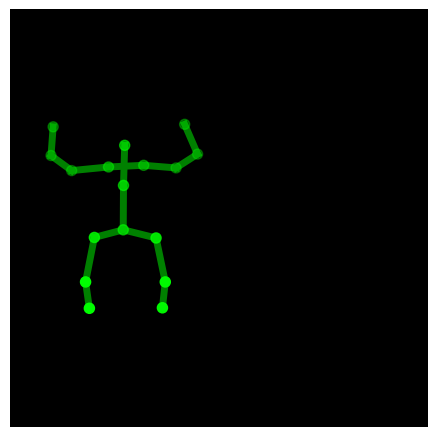

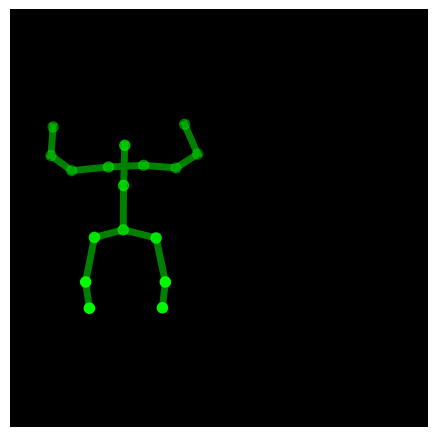

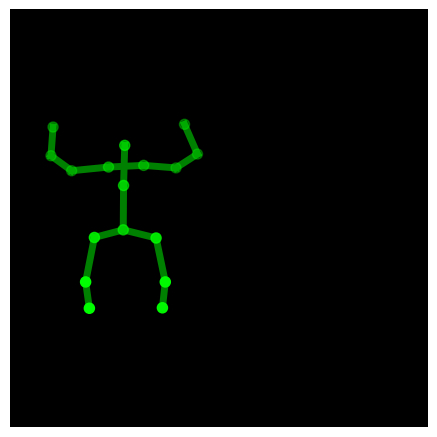

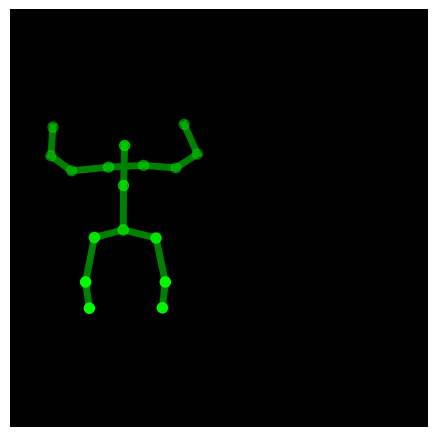

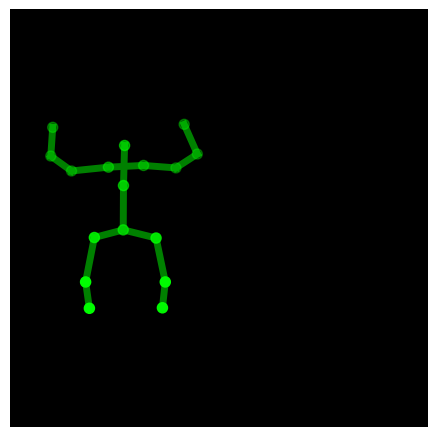

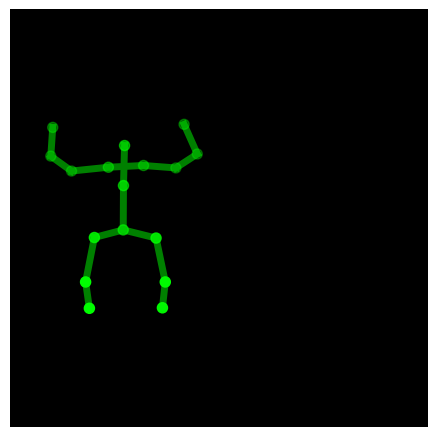

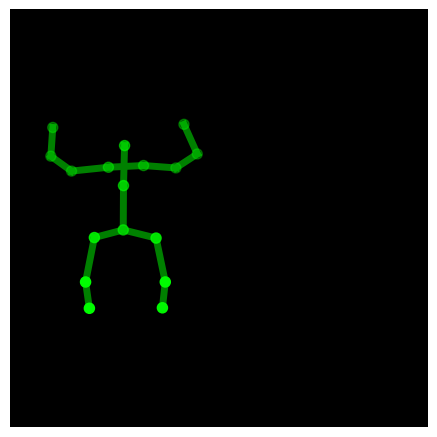

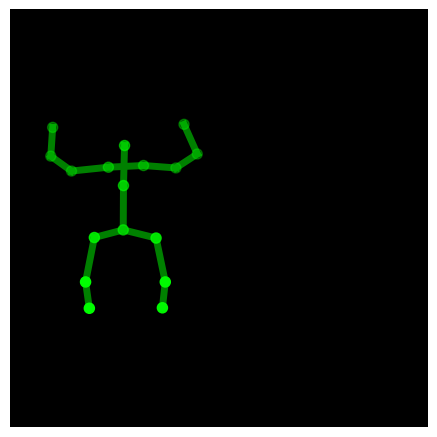

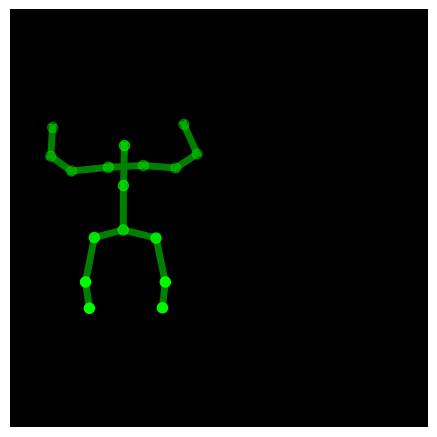

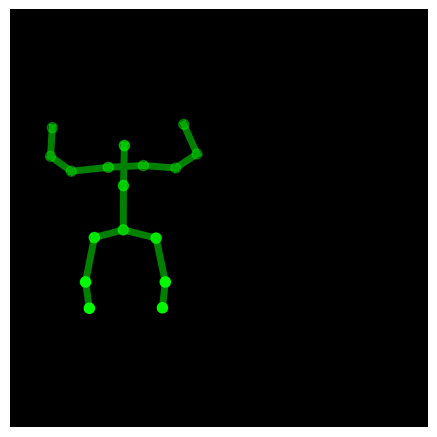

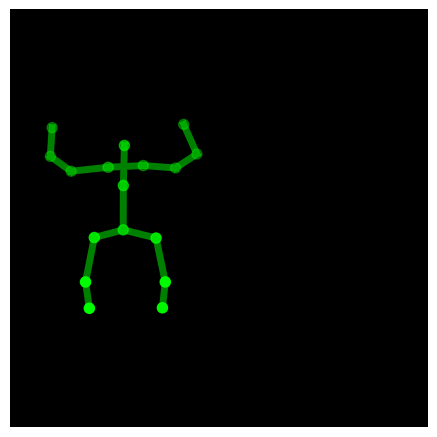

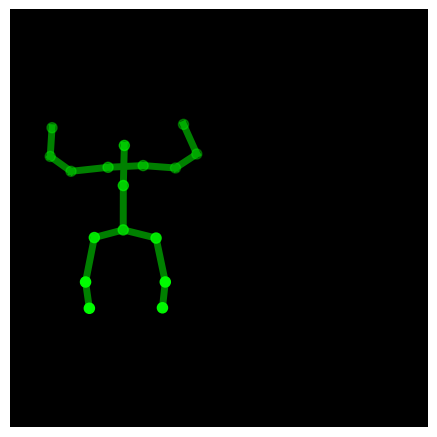

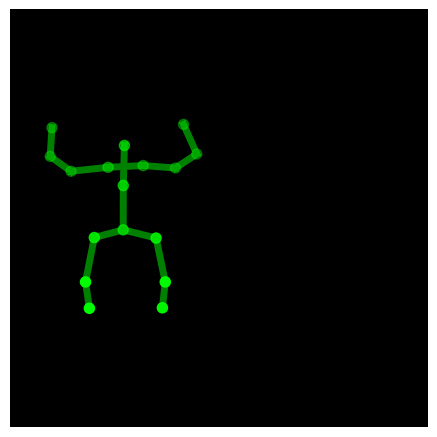

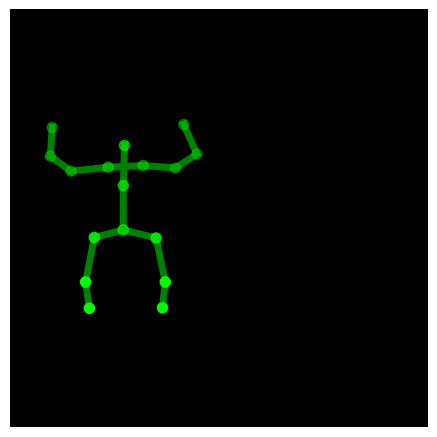

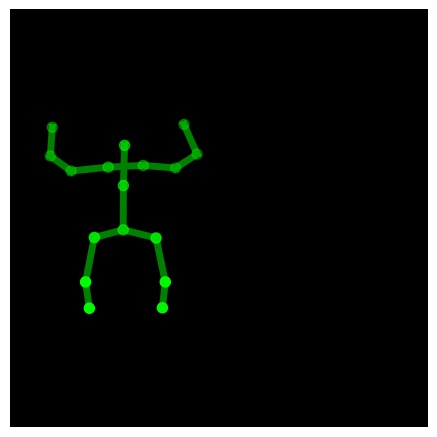

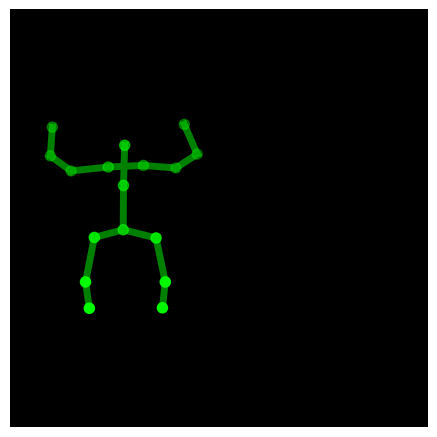

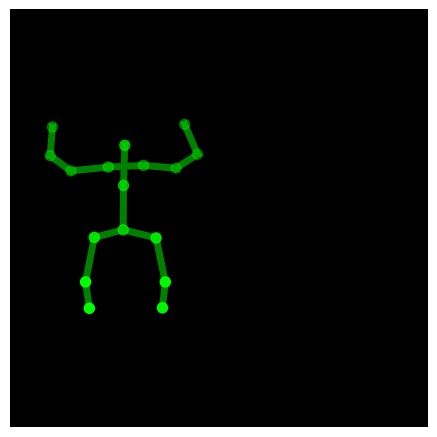

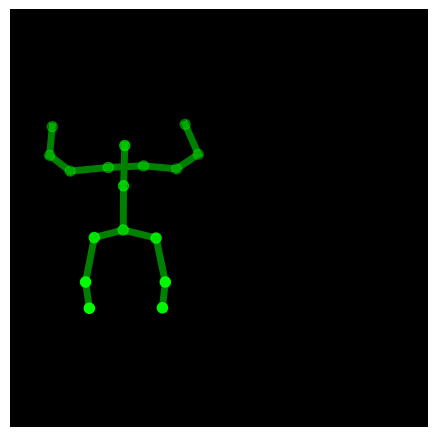

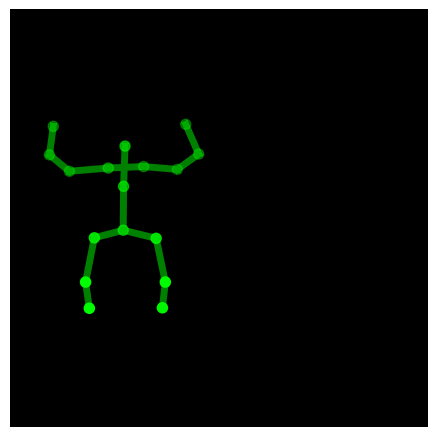

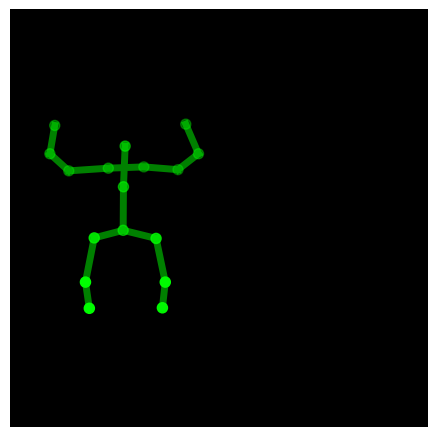

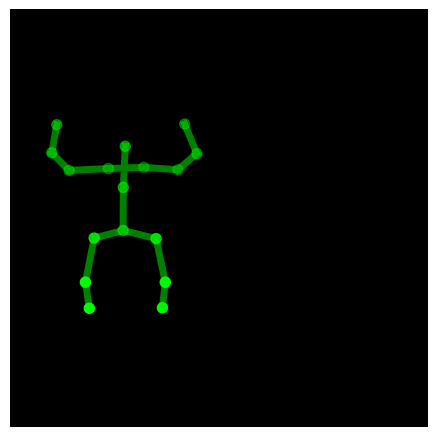

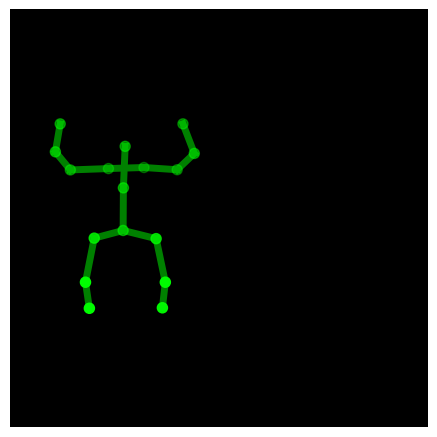

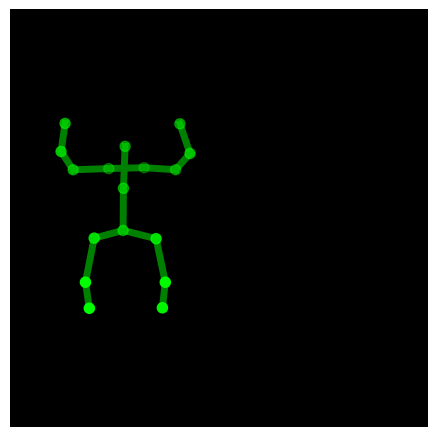

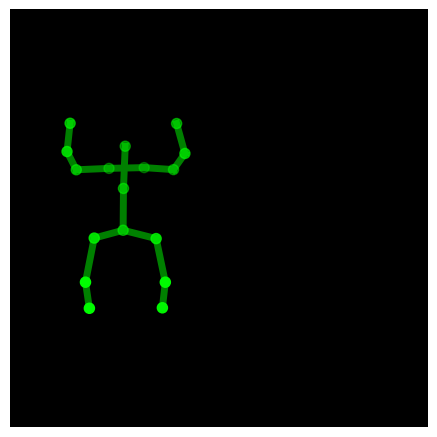

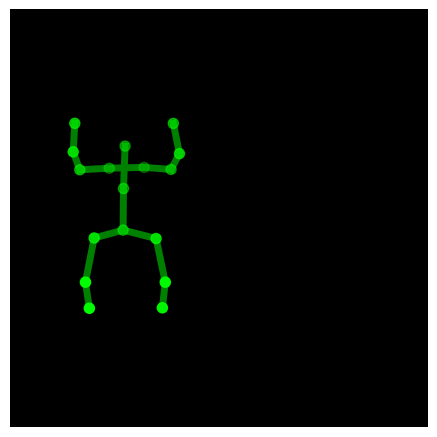

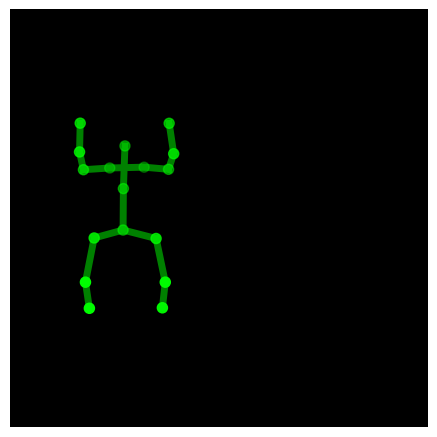

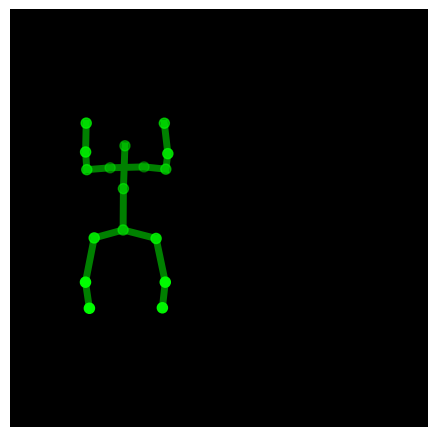

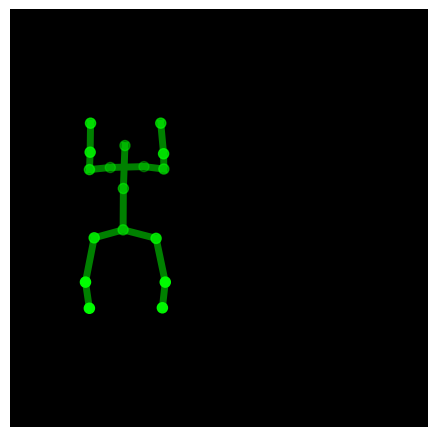

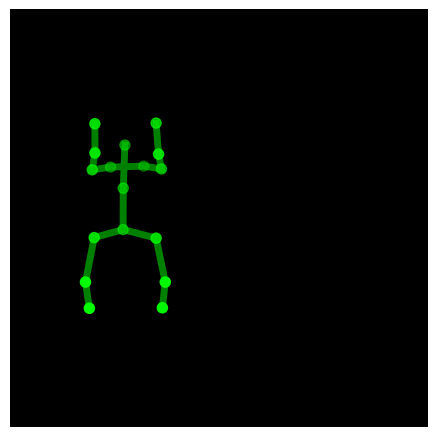

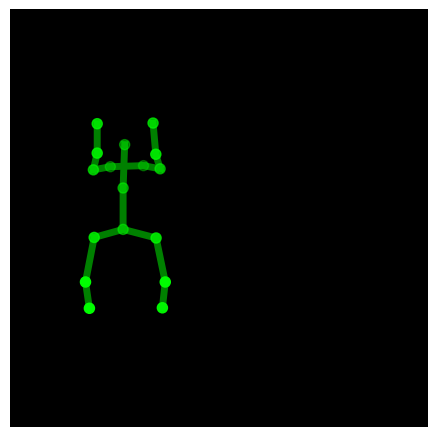

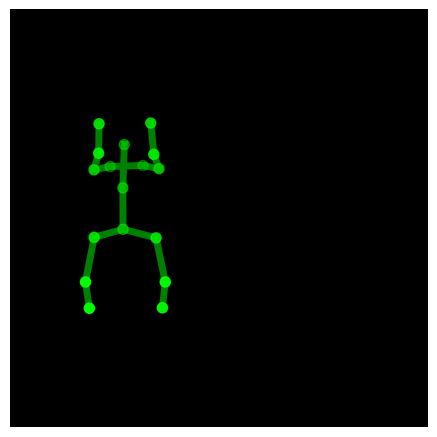

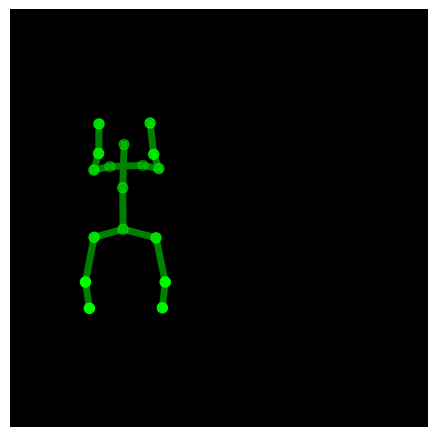

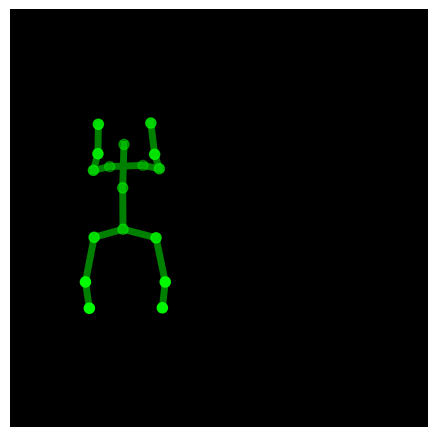

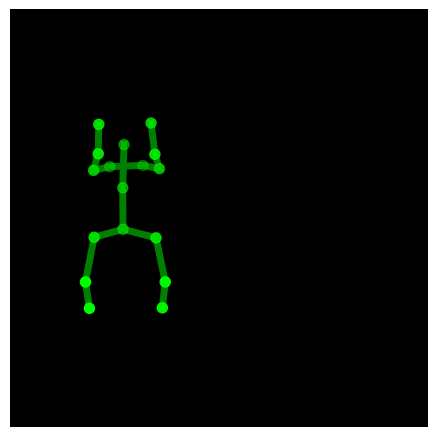

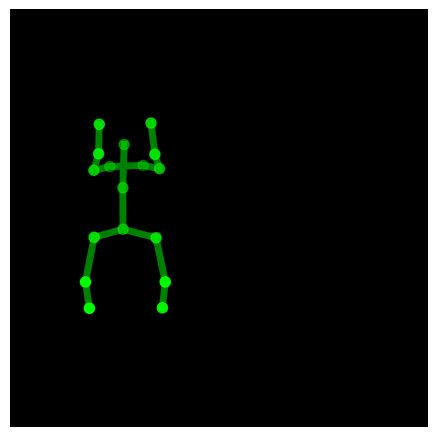

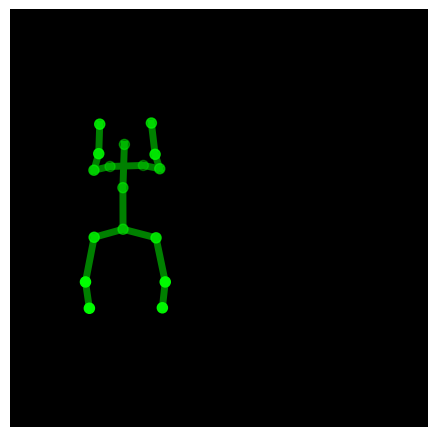

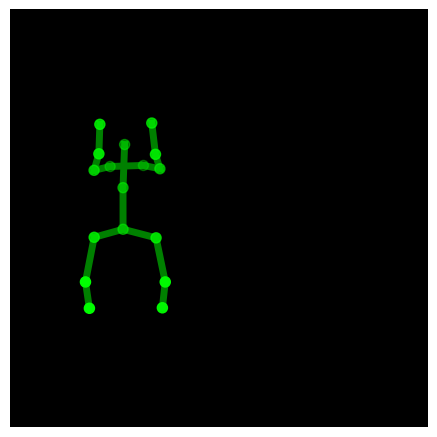

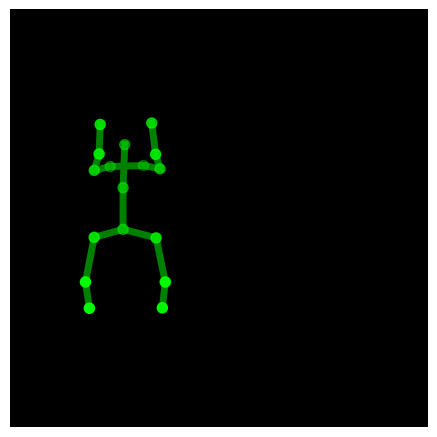

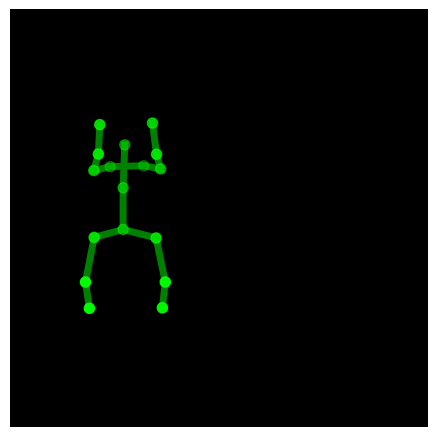

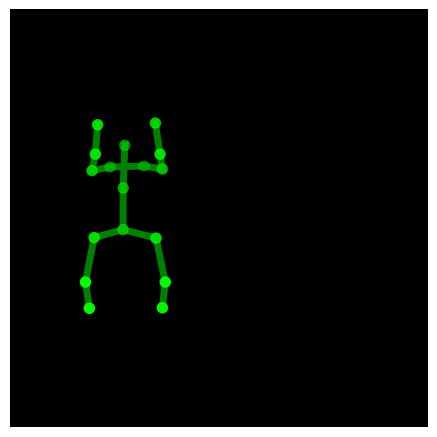

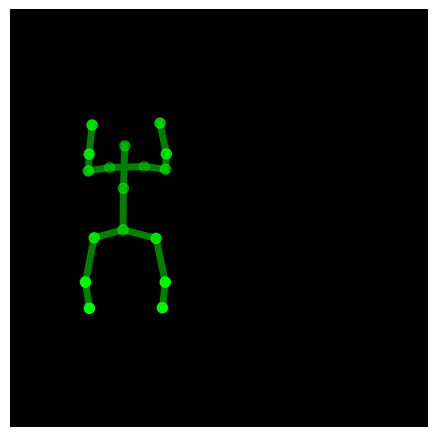

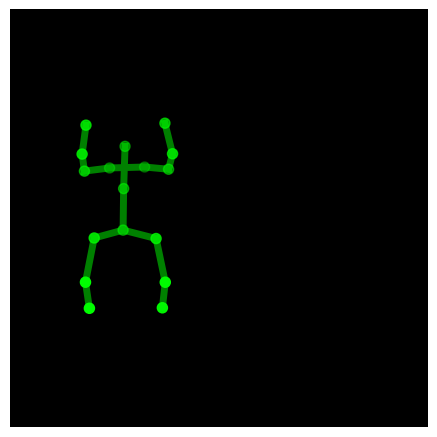

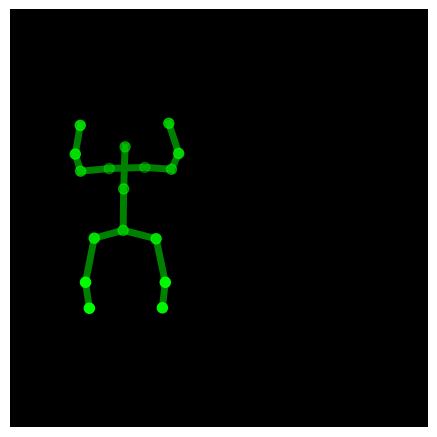

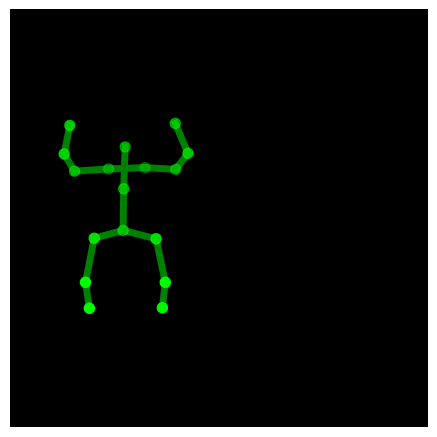

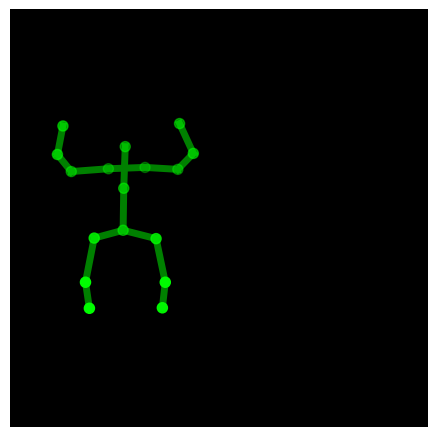

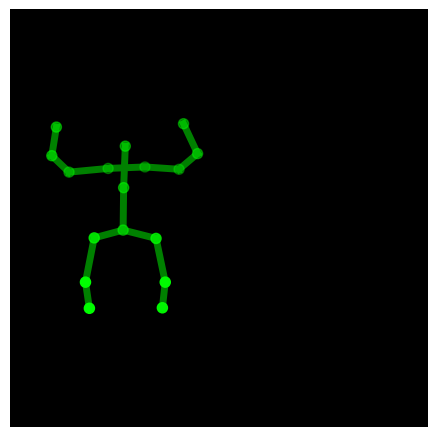

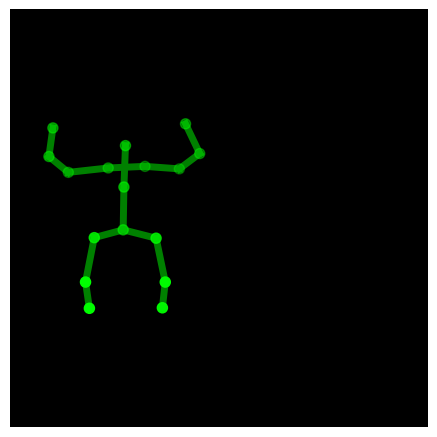

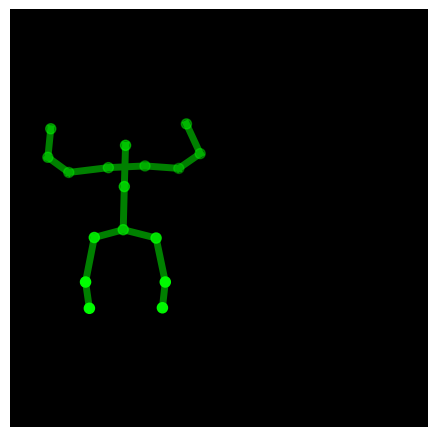

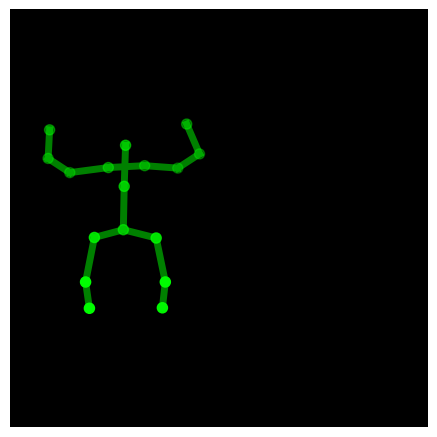

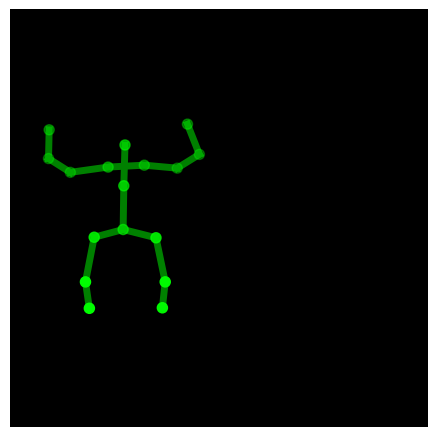

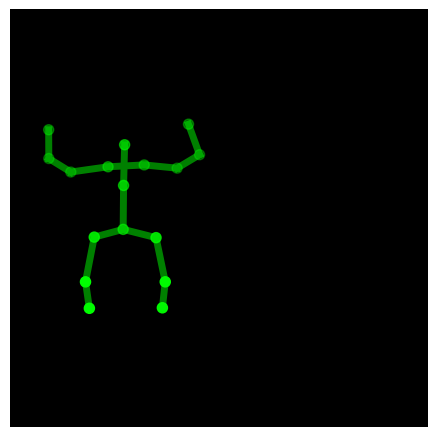

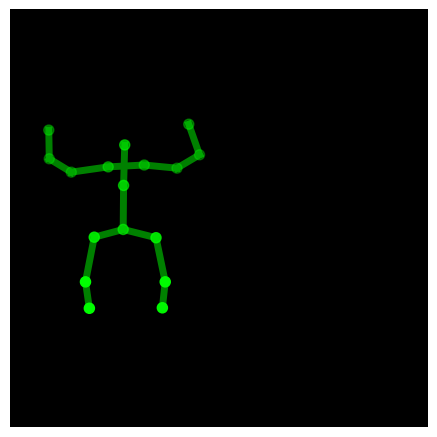

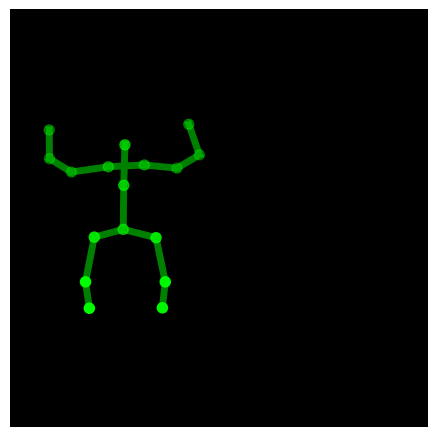

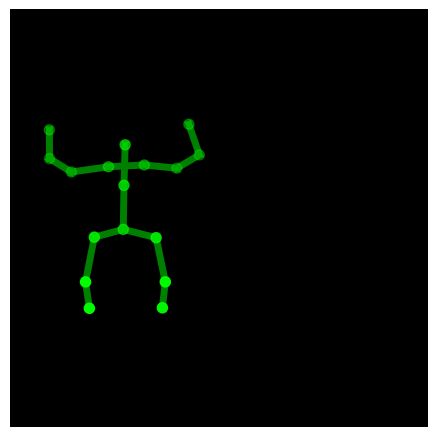

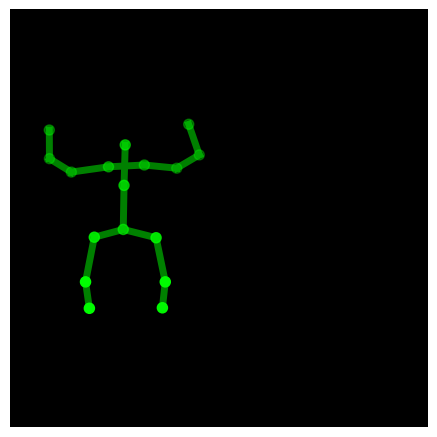

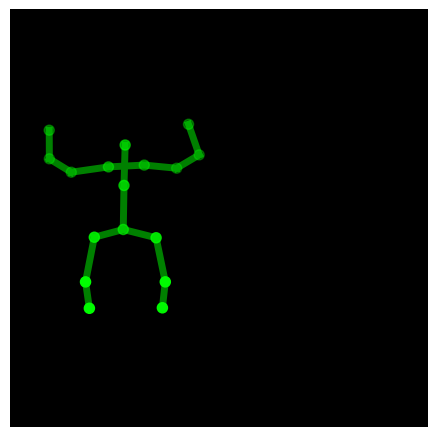

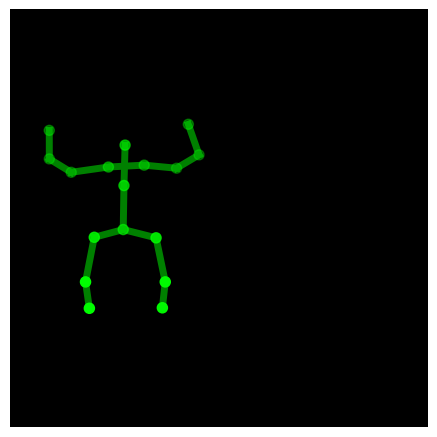

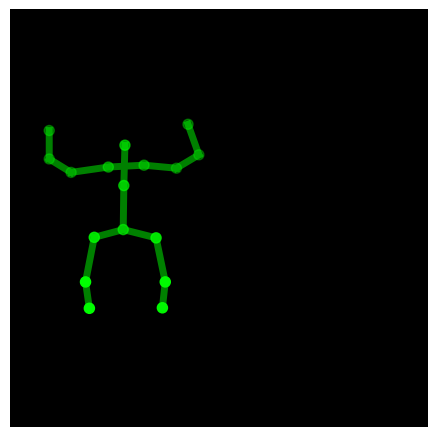

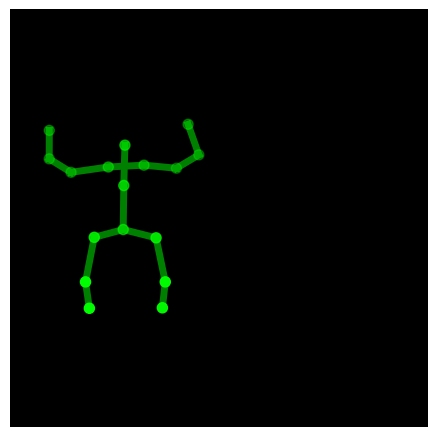

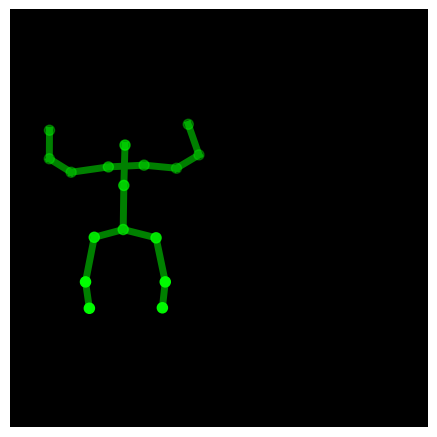

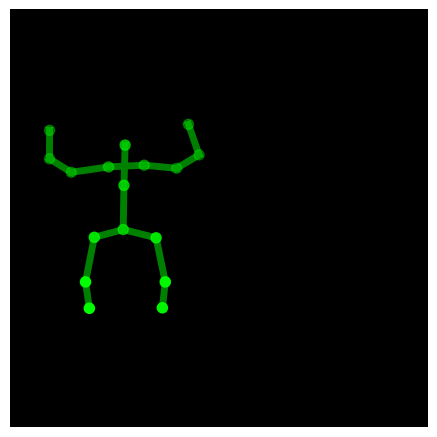

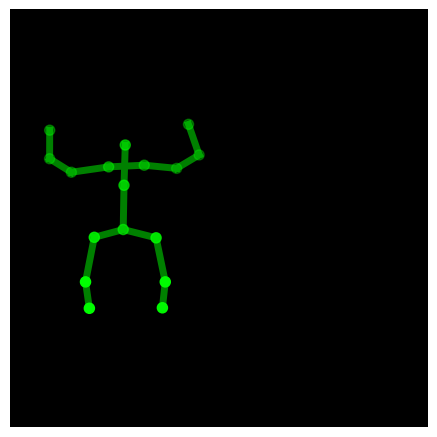

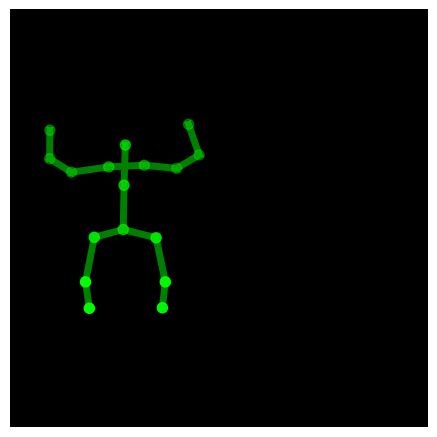

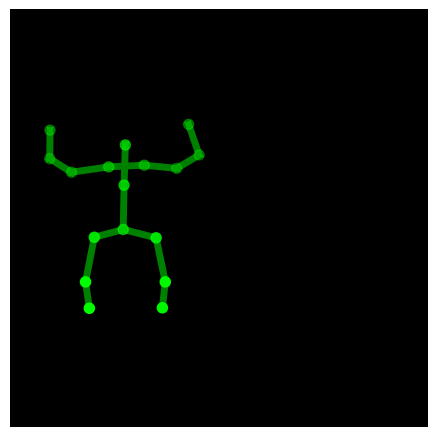

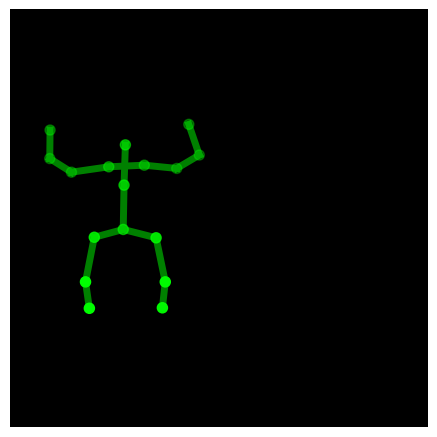

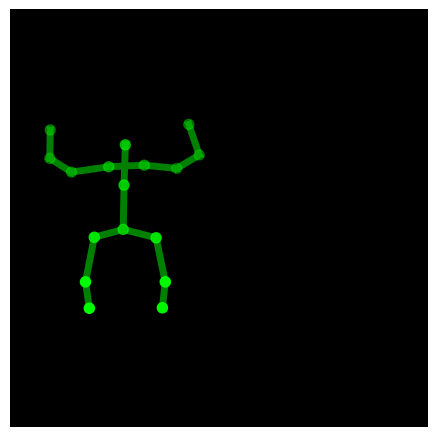

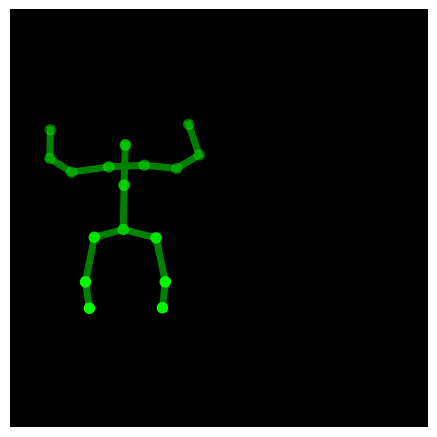

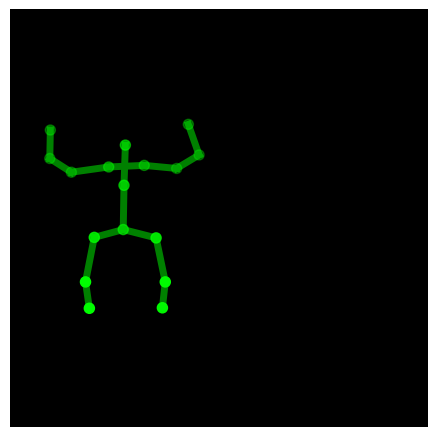

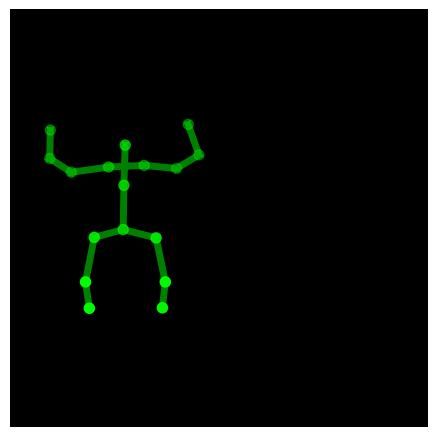

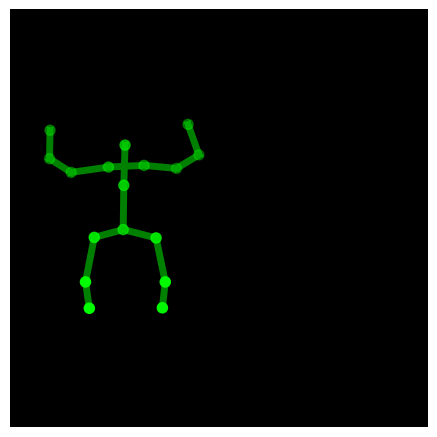

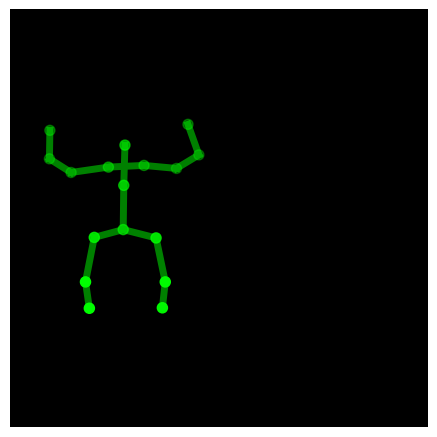

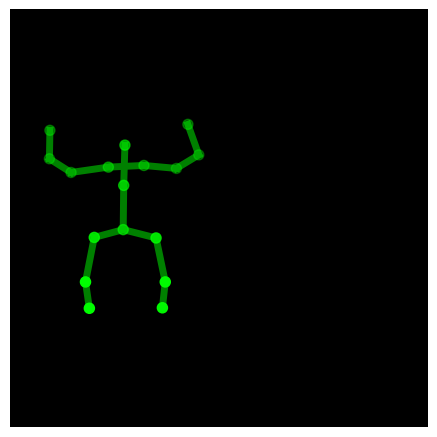

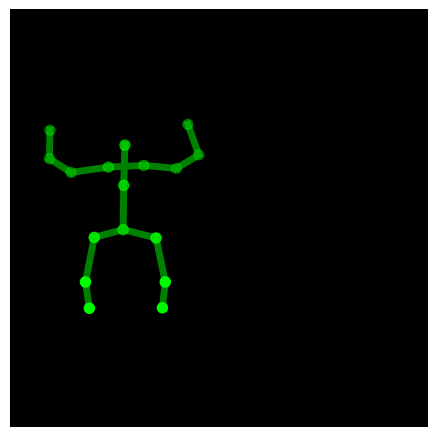

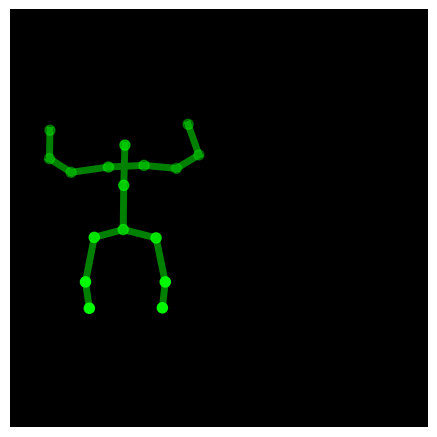

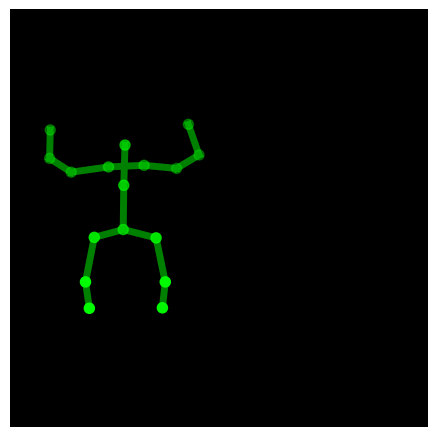

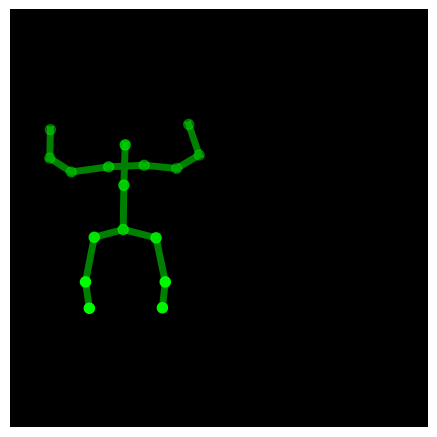

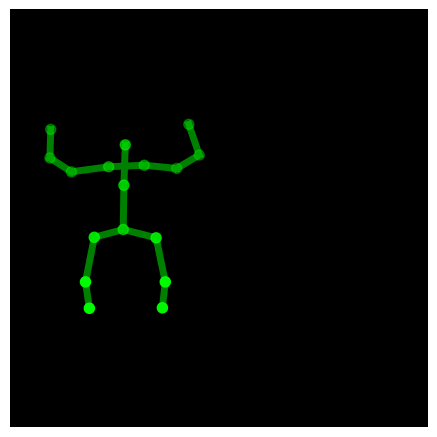

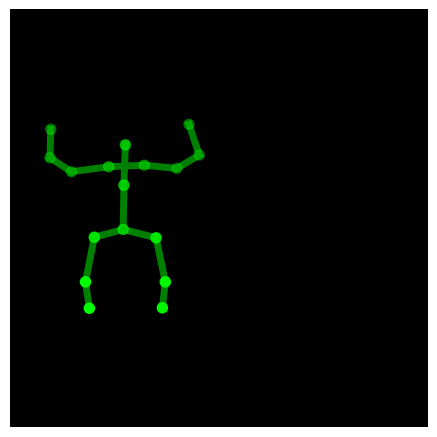

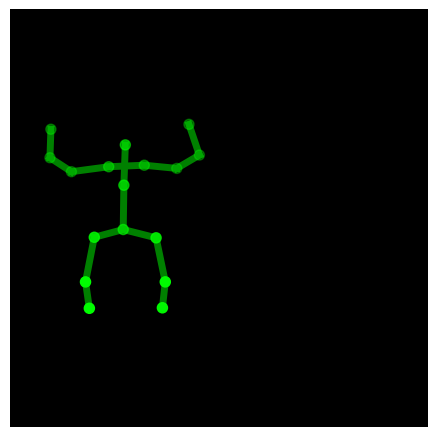

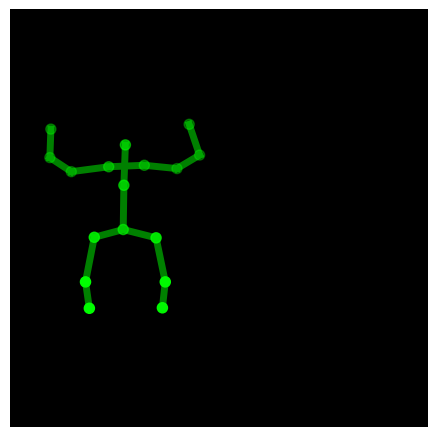

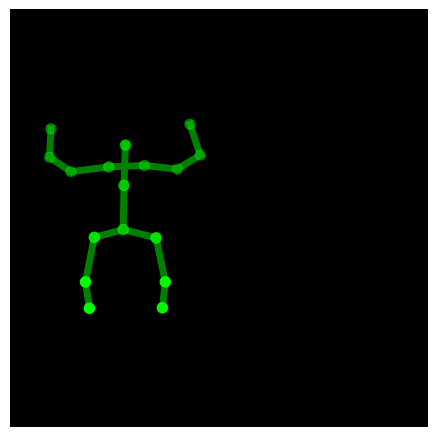

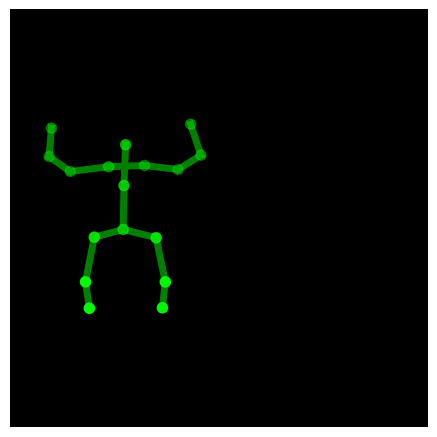

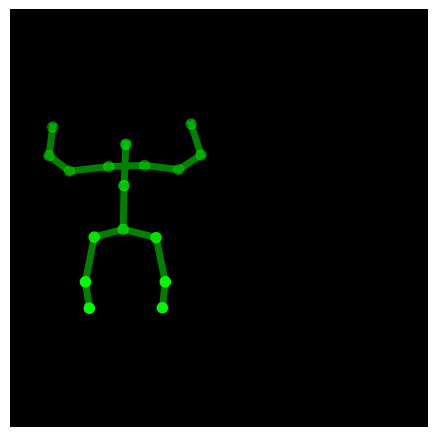

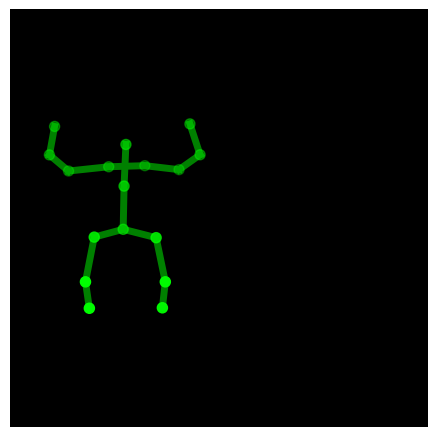

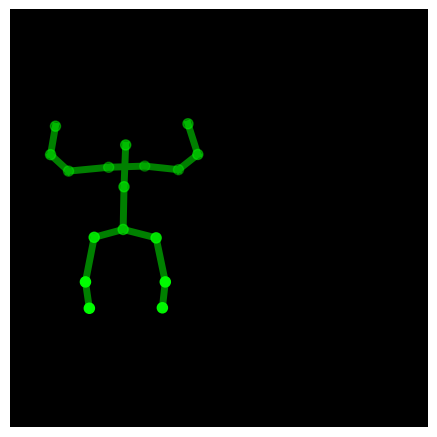

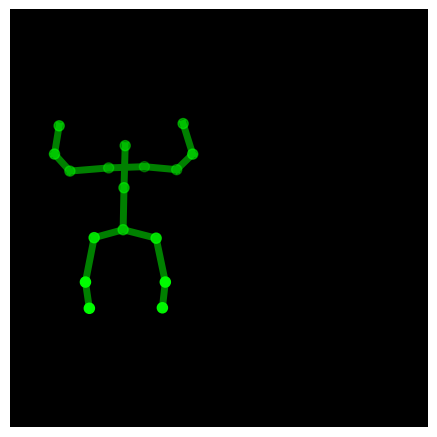

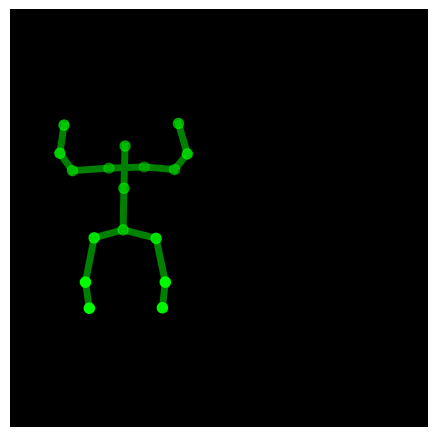

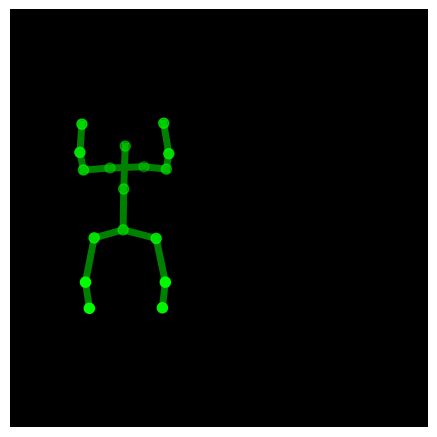

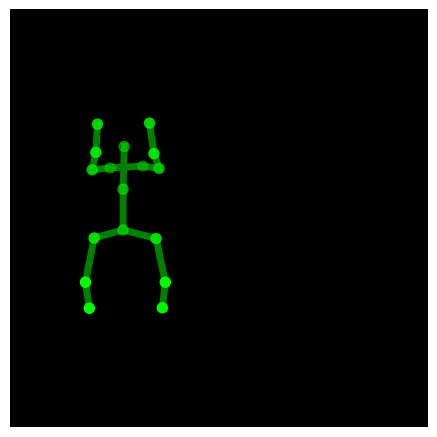

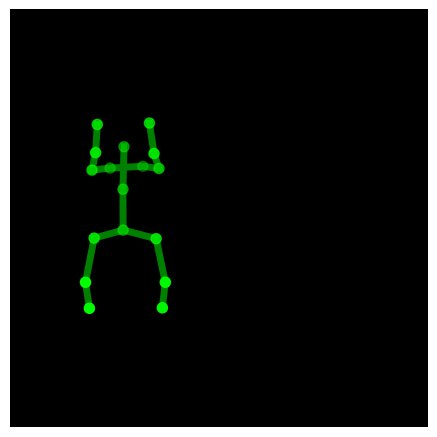

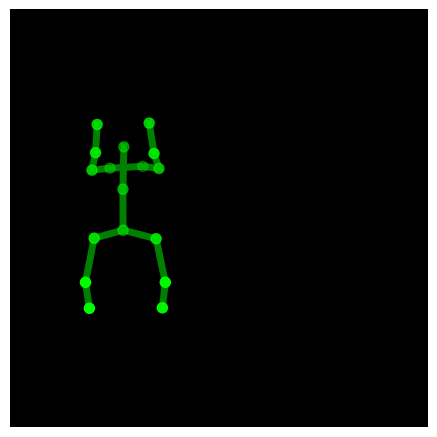

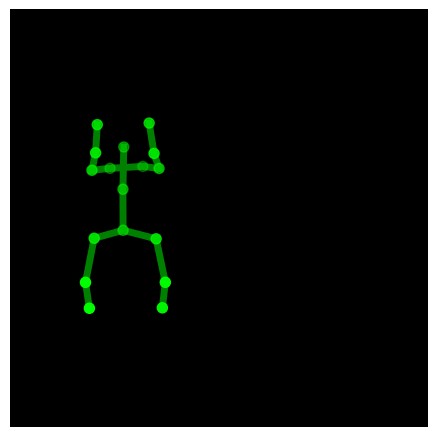

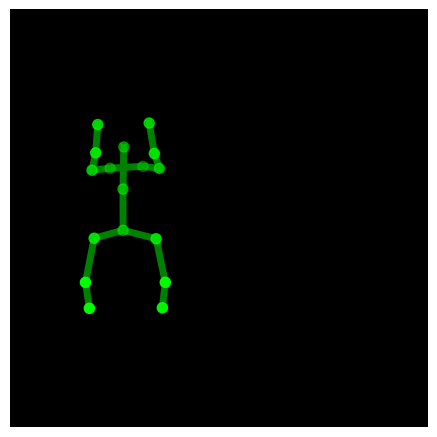

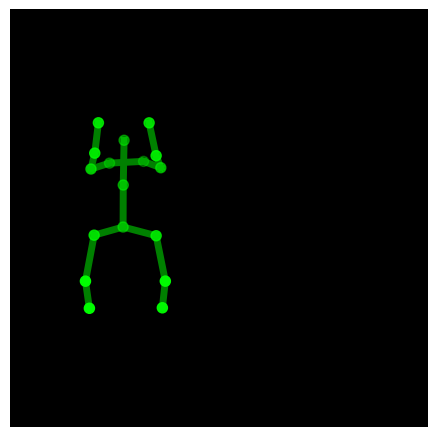

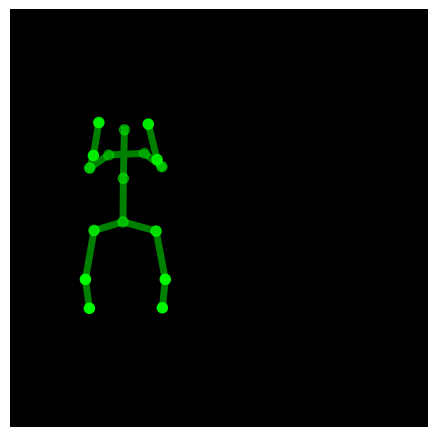

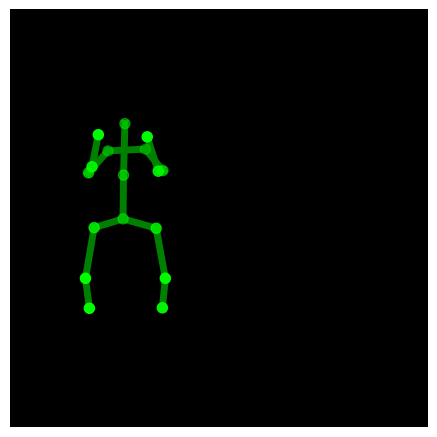

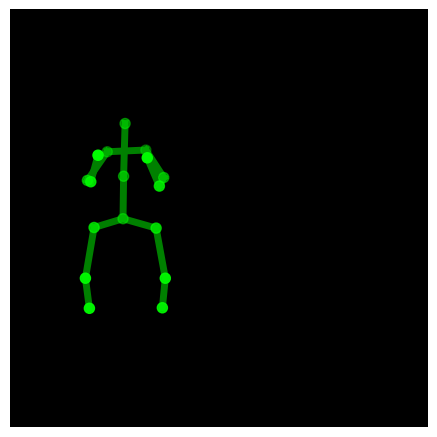

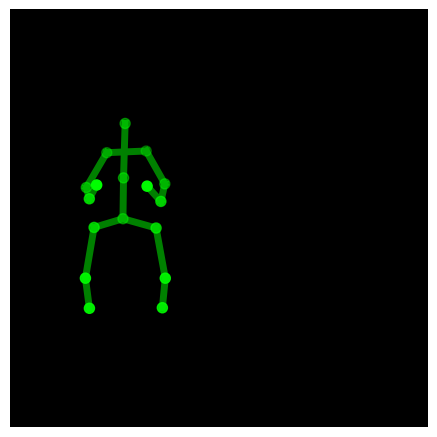

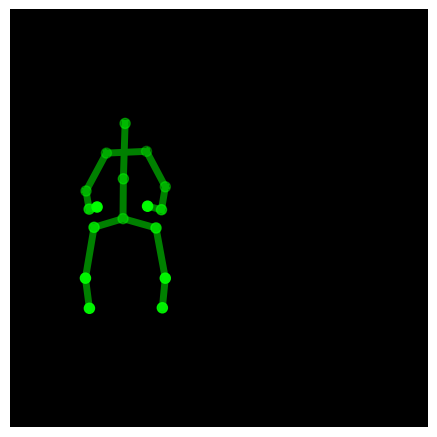

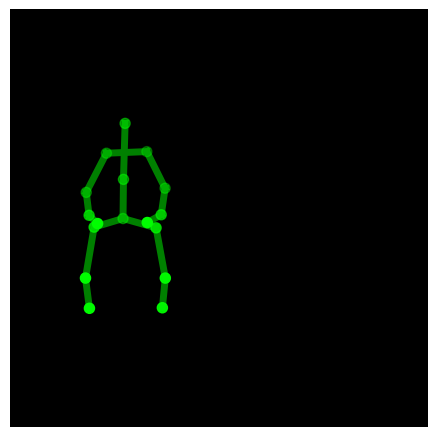

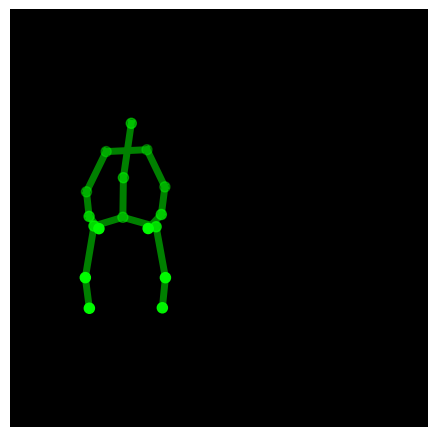

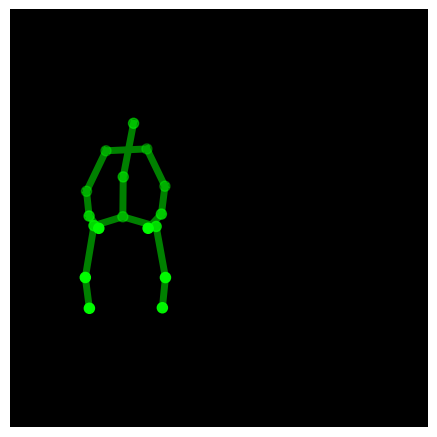

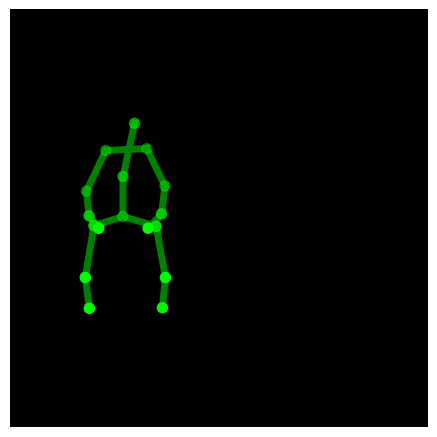

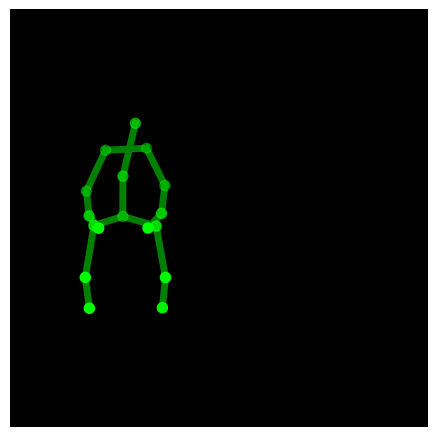

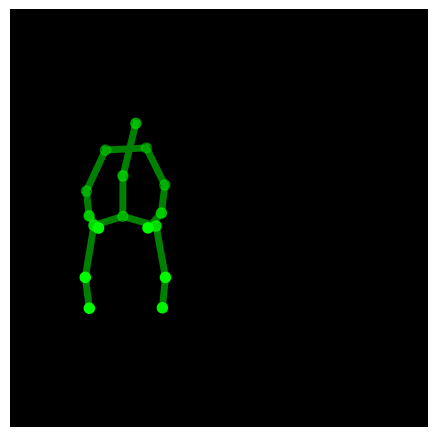

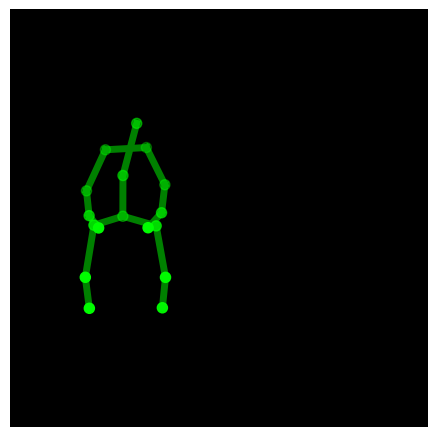

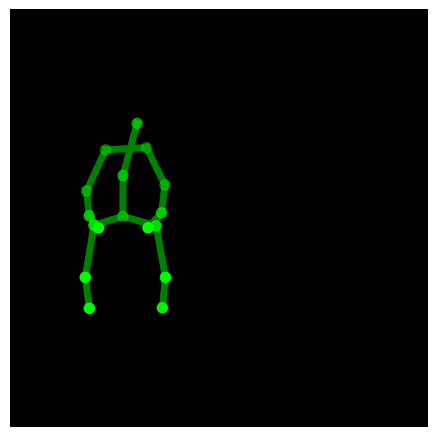

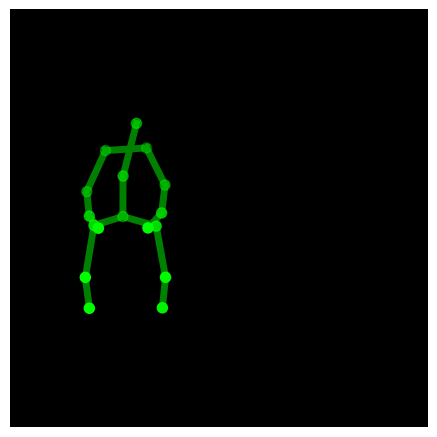

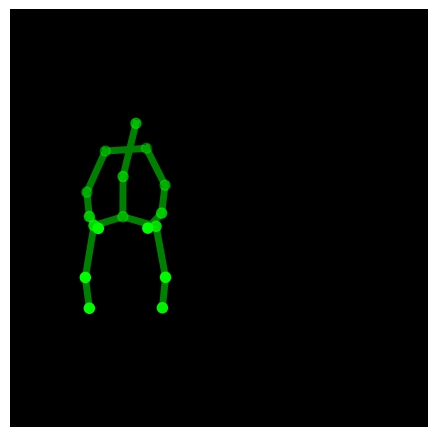

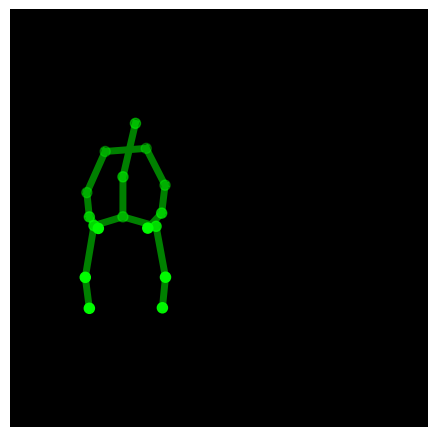

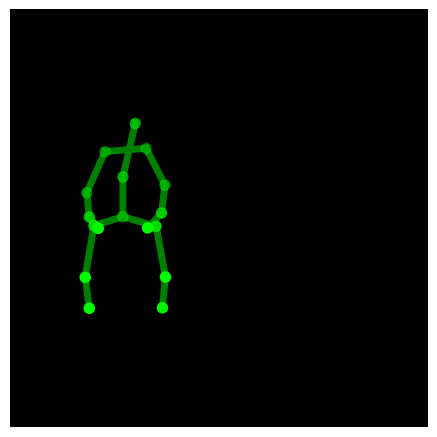

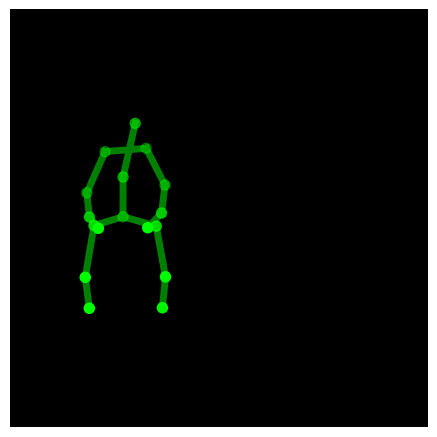

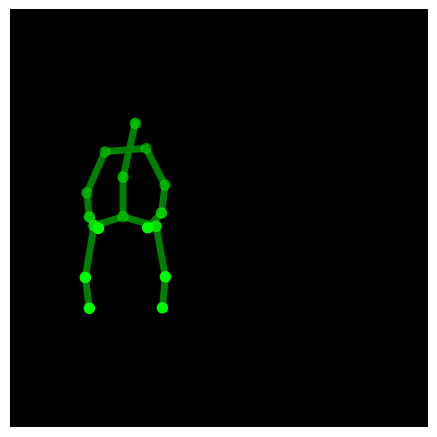

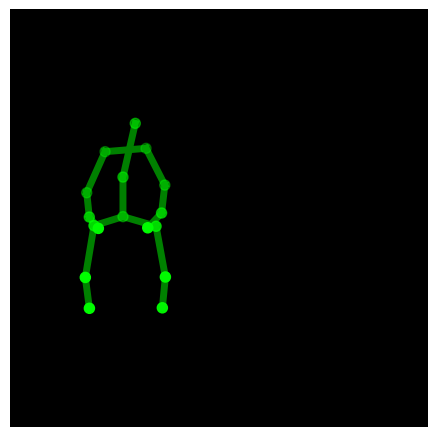

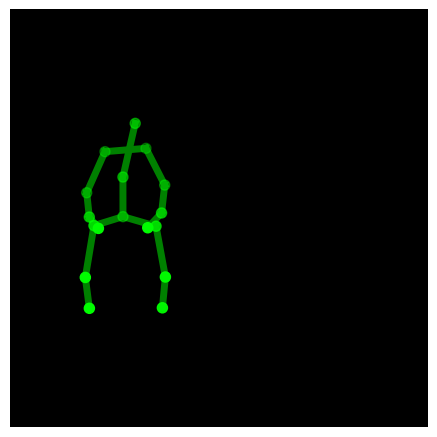

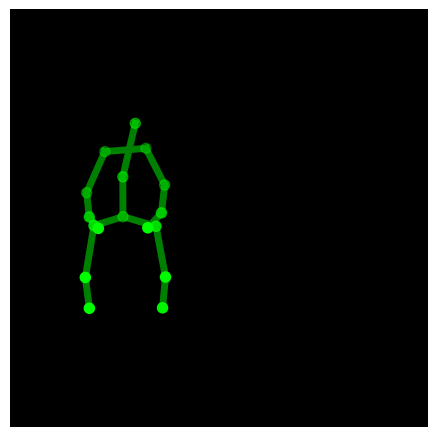

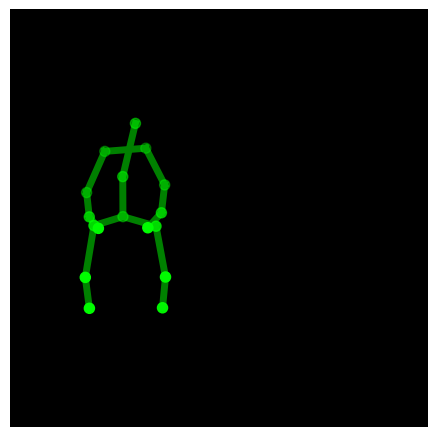

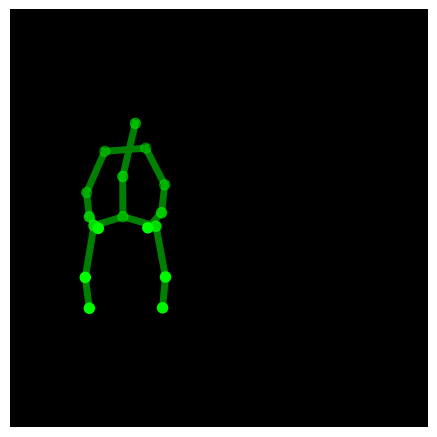

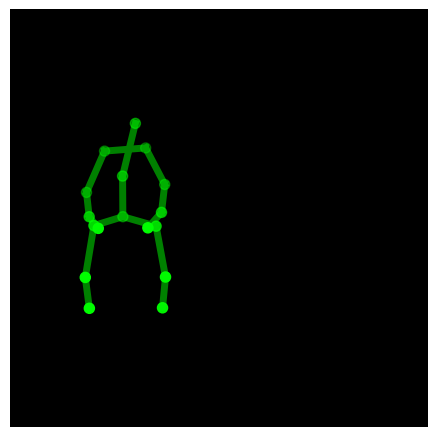

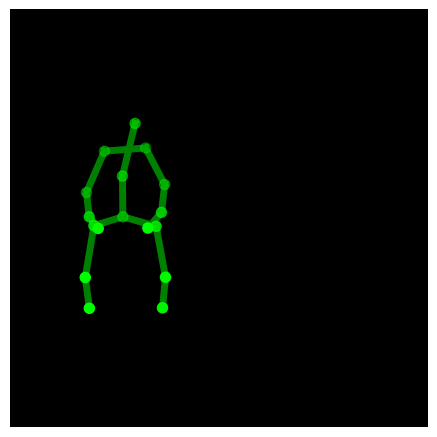

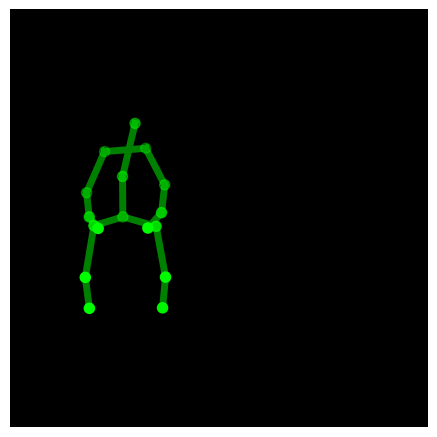

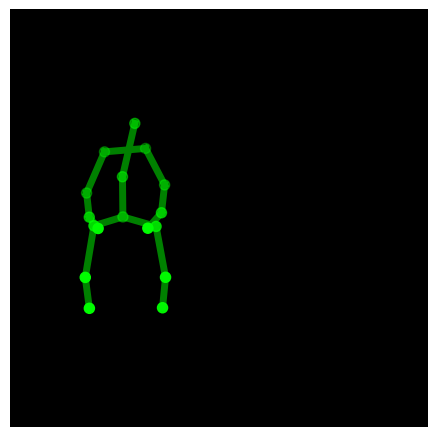

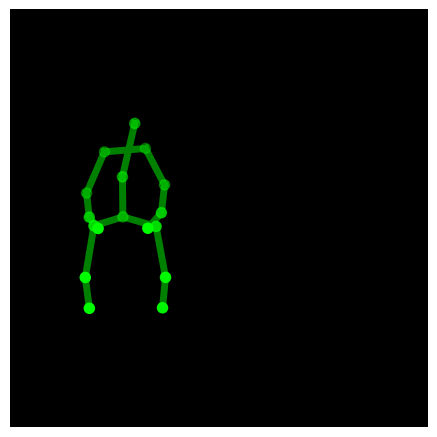

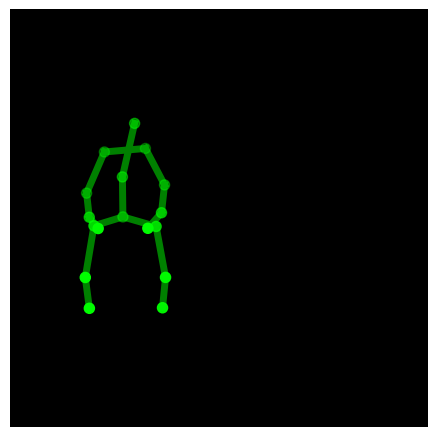

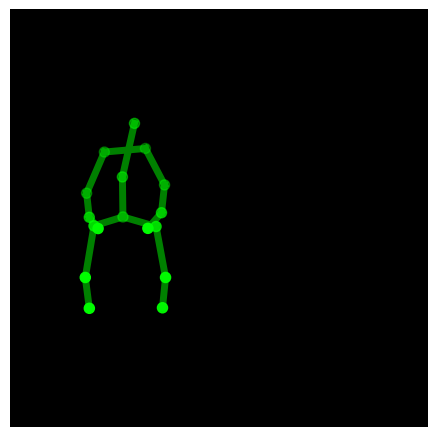

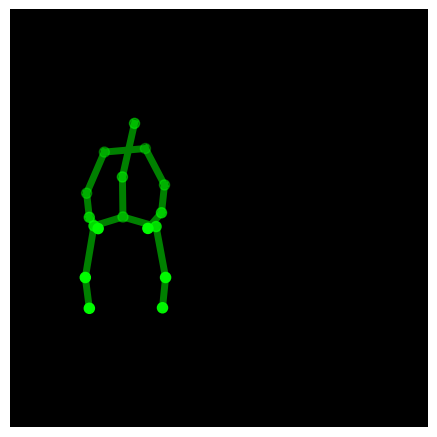

In [78]:
#Start plotting skeletons
images=[]
for i in range(1,len(blaze_coord['positions'])):
    #draw blazepose
    black_image_bla = np.zeros((height,width,3), np.uint8)
    sklt_blaze = convertir_blazepose_en_openpose(blaze_coord['positions'][str((float(i)))],Body_parts_strToNum)
    frame_image_bla = draw_humans(black_image_bla, sklt_blaze, CocoColors_parts_bla, CocoColors_pairs_bla)
    frame_image_bla = cv2.flip(frame_image_bla, 1)
    cv2.putText(frame_image_bla,"Blazepose Skeleton", (int(width/8),50), cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 255, 255))
    
    ## draw vicon
    img_vc = draw_vicon_3d(i, width, height)
#     print(type(img_vc))
    img_vc2 = cv2.resize(img_vc, size, interpolation = cv2.INTER_AREA)
    img_vc2 = cv2.flip(img_vc2, 1)
    cv2.putText(img_vc2,"Vicon Skeleton", (int(width/8),50), cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 255, 255))
    
    ## draw kinect
    black_image_kn = np.zeros((height,width,3), np.uint8)
    sklt = openpose_coord_kn['positions'][str(float(i))]
    frame_image = draw_humans_kinect(black_image_kn,sklt)
    frame_image_kn = cv2.flip(frame_image, 0)
    cv2.putText(frame_image_kn,"Kinect Skeleton", (int(width/8),50), cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 255, 255))
    
    #draw openpose
    black_image_op = np.zeros((height,width,3), np.uint8)
    sklt = openpose_coord['positions'][str(float(i))]
    frame_image_op = draw_humans(black_image_op,sklt, CocoColors_parts, CocoColors_pairs)
    cv2.putText(frame_image_op,"Openpose Skeleton", (int(width/8),50), cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 255, 255))
    
    #draw alphapose
    black_image_ap = np.zeros((height,width,3), np.uint8)
    if str(i) in openpose_coord_ap['positions']:
        sklt_alpha = convertir_alphapose_en_openpose(openpose_coord_ap['positions'][str(i)],Body_parts_strToNum)
        #     sklt = openpose_coord_ap['positions'][str(int(i))]
        frame_image_ap = draw_humans(black_image_ap,sklt_alpha, CocoColors_parts, CocoColors_pairs)
    else:
        frame_image_ap = black_image_ap
    cv2.putText(frame_image_ap,"Alphapose Skeleton", (int(width/8),50), cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 255, 255))
    
    glob = np.concatenate((frame_image_op, frame_image_ap, frame_image_bla, frame_image_kn,img_vc2), axis = 1)
#     print(glob.shape)
#     cv2.imshow("aimage",glob)
    images.append(glob)
    #cv2.imshow("Skeleton",glob)
    #result.write(glob)
    #cv2.waitKey(1)

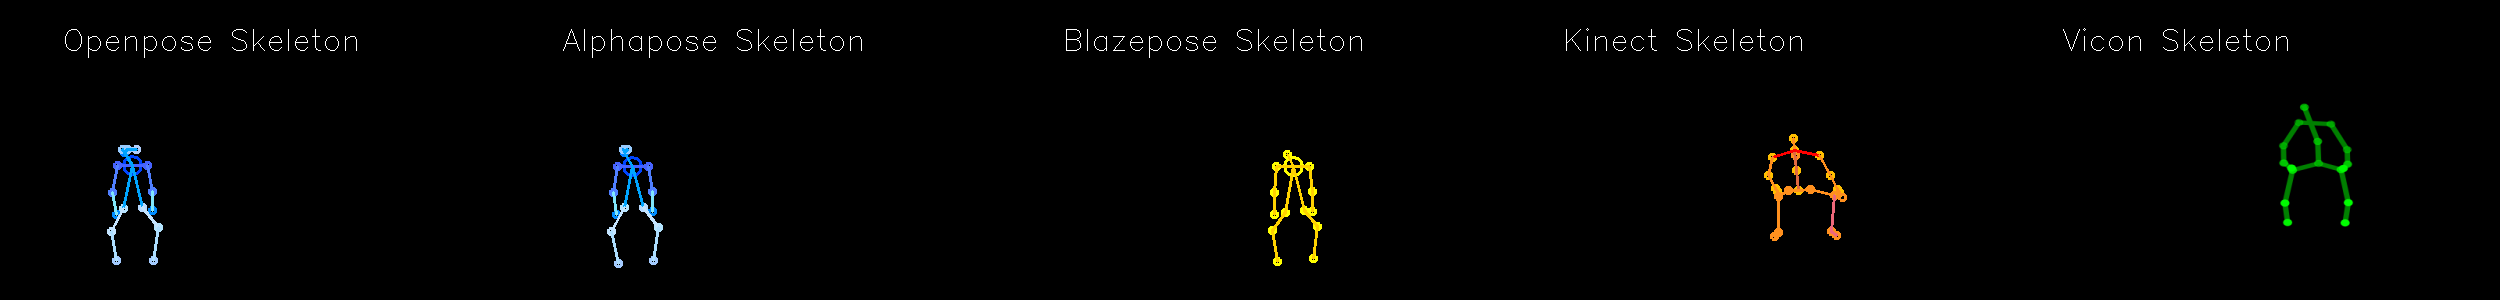

In [79]:
from IPython.display import Image
from numpngw import write_apng

#imageio.mimsave('a2c.gif', [np.array(img) for i, img in enumerate(images) if i%2 == 0], fps=29)
write_apng('outvideo.png', images, delay=60)
Image(filename='outvideo.png')